# LIBRARIES IMPORTATION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from scipy.stats.mstats import winsorize

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')


# DATA IMPORTATION

In [2]:
crop_df = pd.read_csv(r"C:\Users\DELL\Desktop\Dataset\Crop_recommendation.csv")
crop_df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [3]:
crop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [4]:
# Missing values
missing = crop_df.isna().sum()
missing[missing > 0]

Series([], dtype: int64)

In [5]:
# Duplicated
crop_df.duplicated().sum()

np.int64(0)

In [6]:
num_cols = crop_df.select_dtypes(include = ['int', 'float'])
num_cols.head()

,N,P,K,temperature,humidity,ph,rainfall
0,90,42,43,20.879744,82.002744,6.502985,202.935536
1,85,58,41,21.770462,80.319644,7.038096,226.655537
2,60,55,44,23.004459,82.320763,7.840207,263.964248
3,74,35,40,26.491096,80.158363,6.980401,242.864034
4,78,42,42,20.130175,81.604873,7.628473,262.717340


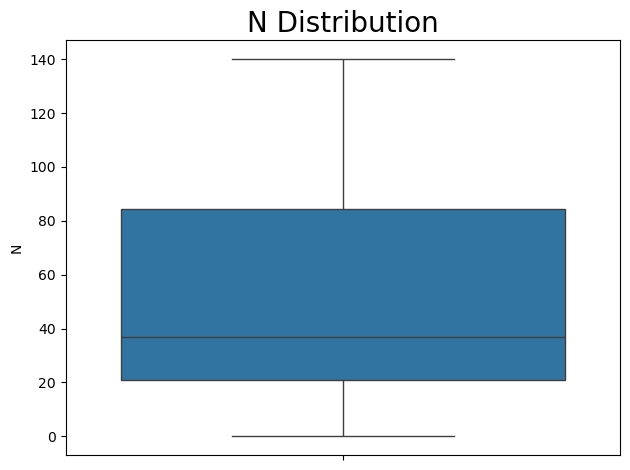

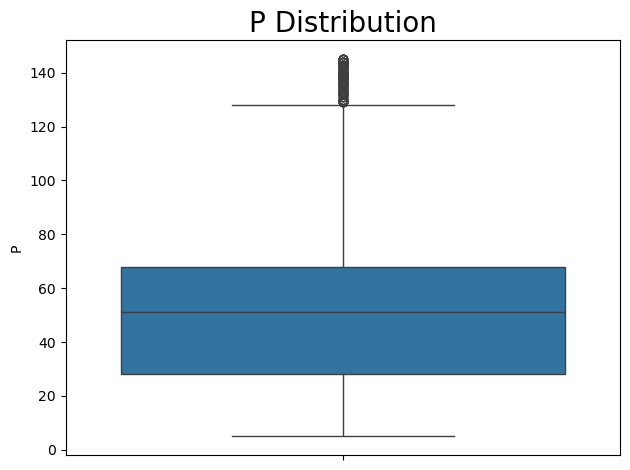

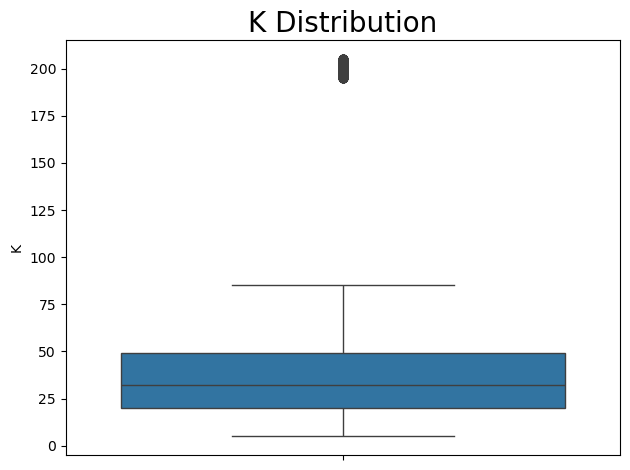

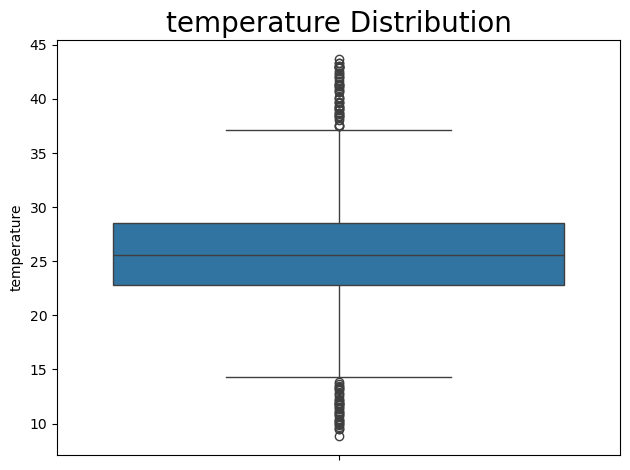

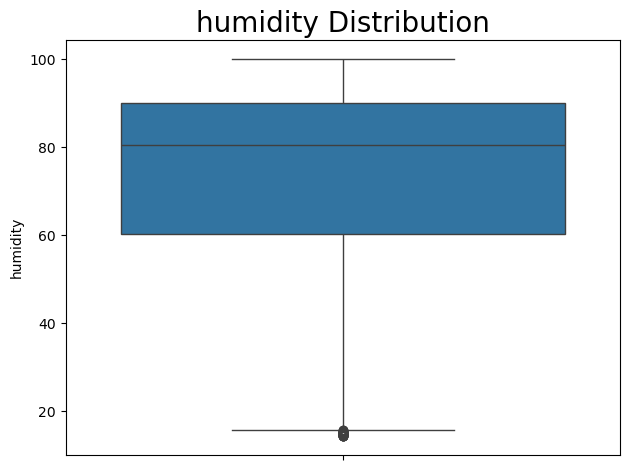

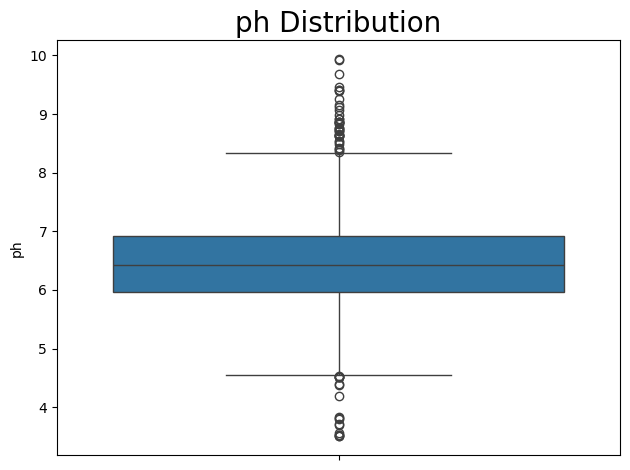

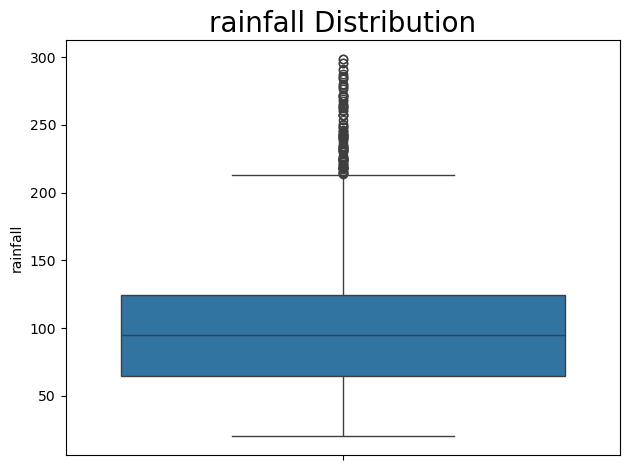

In [7]:
# Outliers detection
for col in num_cols:
    sns.boxplot(crop_df[col], orient = 'x')
    plt.title(f'{col} Distribution', fontsize = 20, y = 1.0)
    plt.tight_layout()
    plt.show()

In [8]:
# Removing outliers
for col in num_cols:
    crop_df[col] = winsorize(crop_df[col], limits = [0.075, 0.075])

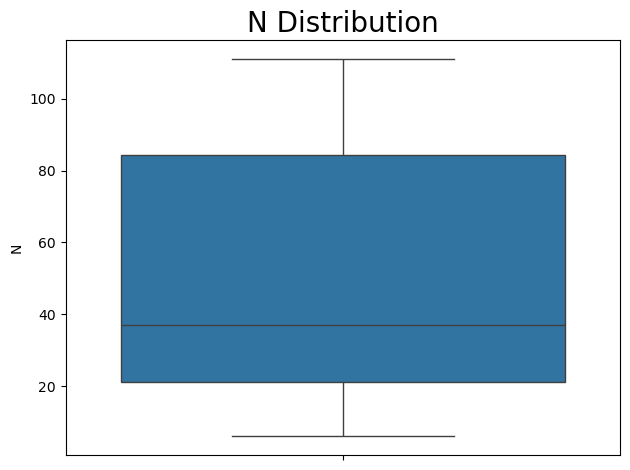

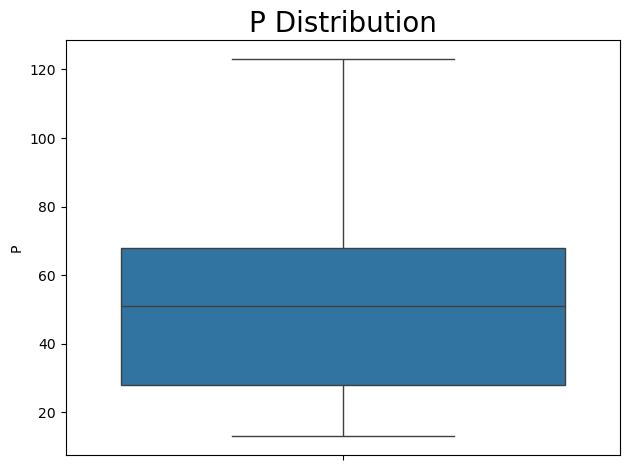

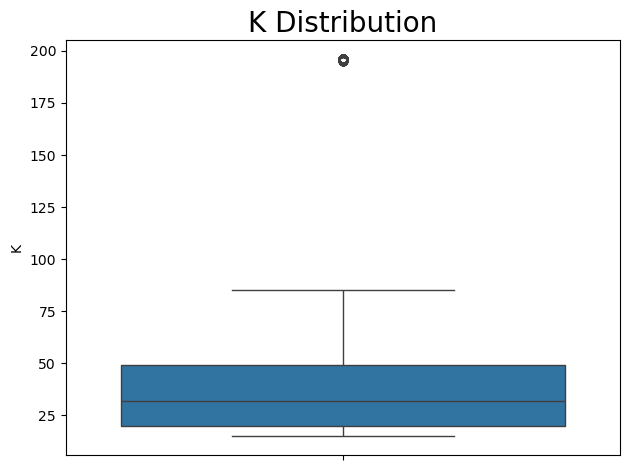

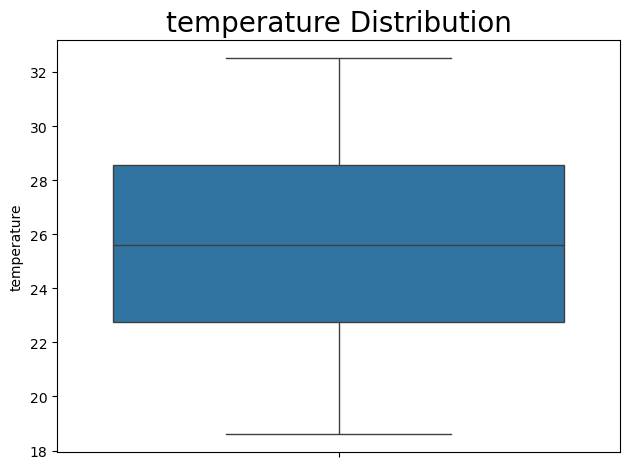

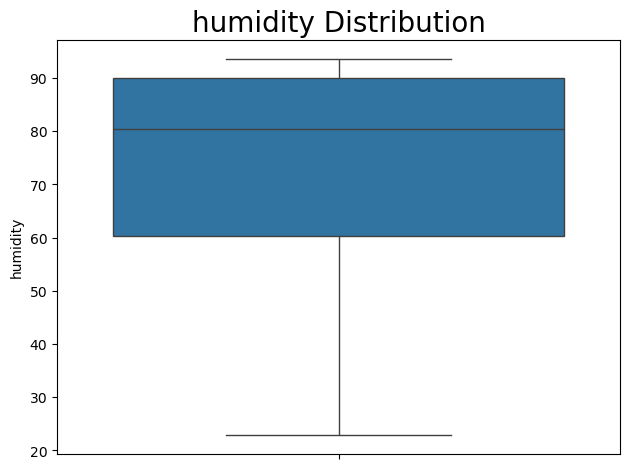

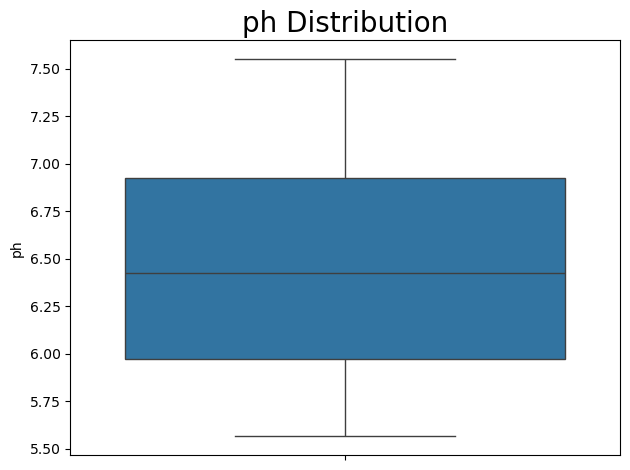

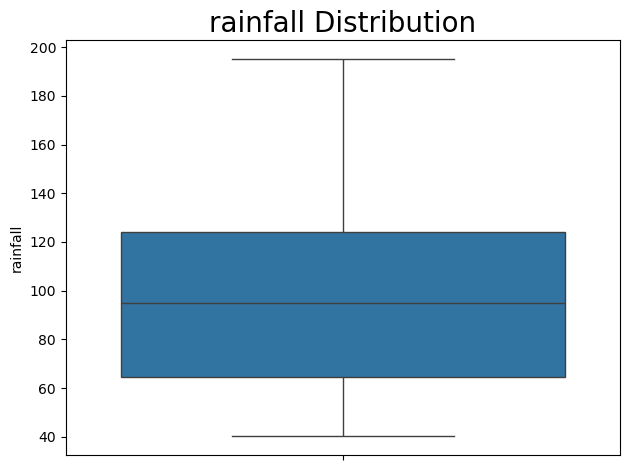

In [9]:
# Outliers detection
for col in num_cols:
    sns.boxplot(crop_df[col], orient = 'x')
    plt.title(f'{col} Distribution', fontsize = 20, y = 1.0)
    plt.tight_layout()
    plt.show()

# DATA PREPROCESSING

In [10]:
crop_df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.164545,52.740909,48.004091,25.532654,71.719126,6.468339,101.747891
std,35.458848,30.121010,49.357597,4.042909,21.306121,0.607069,47.847204
min,6.000000,13.000000,15.000000,18.623288,22.898456,5.565029,40.165460
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,111.000000,123.000000,196.000000,32.512474,93.678046,7.551364,195.094831


In [11]:
label = LabelEncoder()
crop_df['label'] = label.fit_transform(crop_df['label'])

In [12]:
crop_df['label'].value_counts(normalize = True)

label
20    0.045455
11    0.045455
3     0.045455
9     0.045455
18    0.045455
13    0.045455
14    0.045455
2     0.045455
10    0.045455
19    0.045455
1     0.045455
12    0.045455
7     0.045455
21    0.045455
15    0.045455
0     0.045455
16    0.045455
17    0.045455
4     0.045455
6     0.045455
8     0.045455
5     0.045455
Name: proportion, dtype: float64

In [13]:
X = crop_df.drop('label', axis = 1)
y = crop_df['label']

In [14]:
feature_names = X.columns.tolist()
print(feature_names)

['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']


In [15]:
# Conver into array
X = X.values
y = y.values

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (1760, 7), X_test shape: (440, 7), y_train shape: (1760,), y_test shape: (440,)


In [17]:
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [18]:
X_train_tensor = torch.FloatTensor(X_train_scale)
X_test_tensor = torch.FloatTensor(X_test_scale)

In [19]:
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

In [20]:
print(f"X_train_tensor shape: {X_train_tensor.shape}, X_test_tensor shape: {X_test_tensor.shape}, y_train_tensor shape: {y_train_tensor.shape}, y_test_tensor shape: {y_test_tensor.shape}")

X_train_tensor shape: torch.Size([1760, 7]), X_test_tensor shape: torch.Size([440, 7]), y_train_tensor shape: torch.Size([1760]), y_test_tensor shape: torch.Size([440])


# MODEL BUILDING

In [21]:
# Set a seed for reproducibility
torch.manual_seed(42)

class ClassificationModel(nn.Module):
    def __init__(self, in_features = 7, h1 = 64, h2 = 32, output_target = 22):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.bn1 = nn.BatchNorm1d(h1) # Batch normalization
        self.dropout = nn.Dropout(p = 0.25) # Reduced dropout
        
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2) 
        
        self.output = nn.Linear(h2, output_target)
        
    def forward(self, x):
        # Layer 1
        x = F.relu(self.fc1(x))
        x = self.bn1(x) # Apply batch norm AFTER activation
        x = self.dropout(x) # Apply dropout
        
        # Layer 2
        x = F.relu(self.fc2(x))
        x = self.bn2(x) # Apply batch norm AFTER activation
        
        # Output layer
        x = self.output(x) # No activation, CrossEntropyLoss will apply it
        
        return x


In [22]:
# Initialize the new model
model = ClassificationModel()
print(model)

ClassificationModel(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=32, out_features=22, bias=True)
)


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.00001)

In [24]:
epochs = 1000
train_losses = []
val_losses = []

# Variables for Early Stopping
best_val_loss = float('inf') # Initialize with a very high number
patience = 100 # How many epochs to wait for improvement
patience_counter = 0

print("Starting training...")

for i in range(epochs):
    # Set model to training mode
    model.train()
    optimizer.zero_grad()
    
    # Forward pass on the TRAINING data
    y_train_pred = model.forward(X_train_tensor) 
    
    # Calculate loss against the TRAINING labels
    loss = criterion(y_train_pred, y_train_tensor) 
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item()) 

    # --- VALIDATION PASS ---
    model.eval() # This turns off layers like Dropout for validation
    with torch.no_grad():
        # Forward pass on the VALIDATION (TEST) data
        y_val_pred = model(X_test_tensor)
        
        # Calculate loss against the VALIDATION (TEST) labels
        val_loss = criterion(y_val_pred, y_test_tensor)
        val_losses.append(val_loss.item())

    if i % 50 == 0:
        print(f'Epoch {i}: Train loss: {loss.item():.4f}  Val loss: {val_loss.item():.4f}')

    # --- Early Stopping Logic ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
        # This saves: the architecture, the layers, the forward pass, the weights ,everything
        patience_counter = 0 
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'\nEarly stopping at epoch {i}.')
            print(f'Best validation loss: {best_val_loss:.4f}')
            # Load the best model weights
            model.load_state_dict(torch.load('best_model.pth'))
            break # Exit the loop

print("Training complete.")

Starting training...
Epoch 0: Train loss: 3.1703  Val loss: 3.0988
Epoch 50: Train loss: 1.5236  Val loss: 1.6281
Epoch 100: Train loss: 0.8325  Val loss: 0.7181
Epoch 150: Train loss: 0.5242  Val loss: 0.4153
Epoch 200: Train loss: 0.3483  Val loss: 0.2611
Epoch 250: Train loss: 0.2530  Val loss: 0.1769
Epoch 300: Train loss: 0.2009  Val loss: 0.1286
Epoch 350: Train loss: 0.1660  Val loss: 0.0985
Epoch 400: Train loss: 0.1385  Val loss: 0.0802
Epoch 450: Train loss: 0.1288  Val loss: 0.0686
Epoch 500: Train loss: 0.1078  Val loss: 0.0594
Epoch 550: Train loss: 0.0967  Val loss: 0.0526
Epoch 600: Train loss: 0.0828  Val loss: 0.0479
Epoch 650: Train loss: 0.0766  Val loss: 0.0436
Epoch 700: Train loss: 0.0690  Val loss: 0.0399
Epoch 750: Train loss: 0.0621  Val loss: 0.0369
Epoch 800: Train loss: 0.0590  Val loss: 0.0353
Epoch 850: Train loss: 0.0575  Val loss: 0.0366
Epoch 900: Train loss: 0.0471  Val loss: 0.0365
Epoch 950: Train loss: 0.0492  Val loss: 0.0335
Training complete.


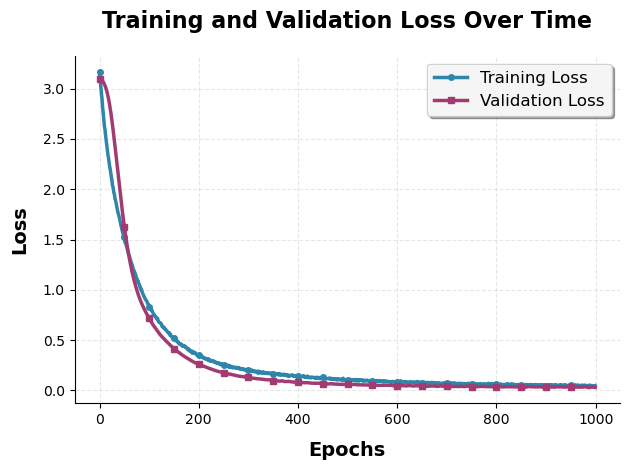

In [25]:
plt.plot(range(epochs), train_losses, label = 'Training Loss', linewidth = 2.5, color = '#2E86AB',  
         marker = 'o', markersize = 4, markevery = max(1, epochs//20))  # Show markers periodically

plt.plot(range(epochs), val_losses, label = 'Validation Loss', linewidth = 2.5, color = '#A23B72',  
          marker = 's', markersize = 4, markevery = max(1, epochs//20))  # Show markers periodically

plt.xlabel('Epochs', fontsize = 14, fontweight = 'bold', labelpad = 10)
plt.ylabel('Loss', fontsize = 14, fontweight = 'bold', labelpad = 10)
plt.title('Training and Validation Loss Over Time', fontsize = 16, fontweight = 'bold', pad = 20)

plt.legend(fontsize = 12, framealpha = 0.9, shadow = True, loc = 'best')

# Customize grid and spines
plt.grid(True, alpha=0.3, linestyle='--')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('Loss.png', dpi = 300, bbox_inches='tight')
plt.show()

In [26]:
model.eval()
with torch.no_grad():
    
    # Get predictions for the entire training set
    train_outputs = model(X_train_tensor)
    
    # Find the class with the highest score (the prediction)
    # dim=1 means we look across the columns (the 22 output classes)
    _, train_predicted_labels = torch.max(train_outputs, 1)
    
    # Compare predicted labels to true labels
    train_correct = (train_predicted_labels == y_train_tensor).sum().item()
    train_total = y_train_tensor.size(0)
    train_accuracy = (train_correct / train_total) * 100

    test_outputs = model(X_test_tensor)
    
    _, test_predicted_labels = torch.max(test_outputs, 1)
    
    # Compare predicted labels to true labels
    test_correct = (test_predicted_labels == y_test_tensor).sum().item()
    test_total = y_test_tensor.size(0)
    test_accuracy = (test_correct / test_total) * 100

print(f"Model Performance")
print(f"Training Accuracy: {train_accuracy:.2f}% ({train_correct} / {train_total})")
print(f"Test Accuracy:     {test_accuracy:.2f}% ({test_correct} / {test_total})")


Model Performance
Training Accuracy: 99.43% (1750 / 1760)
Test Accuracy:     99.32% (437 / 440)


In [27]:
#  Put model in evaluation mode
model.eval()

with torch.no_grad():
    #  Get Raw Predictions (Logits)
    predictions = model(X_test_tensor)
    
    #  Get the Class Index with the highest score
    # dim=1 checks across the columns (classes)
    _, predicted_indices = torch.max(predictions, dim=1)
    
    #  Convert to Numpy
    y_pred_numpy = predicted_indices.cpu().numpy()
    y_true_numpy = y_test_tensor.cpu().numpy()



In [28]:
# Calculate Metrics (Use 'weighted' or 'macro' for multi-class)
print(f"Accuracy:  {accuracy_score(y_true_numpy, y_pred_numpy):.4f}")
print(f"Precision: {precision_score(y_true_numpy, y_pred_numpy, average='weighted', zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_true_numpy, y_pred_numpy, average='weighted', zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_true_numpy, y_pred_numpy, average='weighted', zero_division=0):.4f}")


Accuracy:  0.9932
Precision: 0.9933
Recall:    0.9932
F1 Score:  0.9932


In [29]:
print("\nClassification Report:\n")
print(classification_report(y_true_numpy, y_pred_numpy, target_names=label.classes_))


Classification Report:

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      0.95      0.95        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       1.00      0.95      0.97        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.00      1.00      1.00        20
  

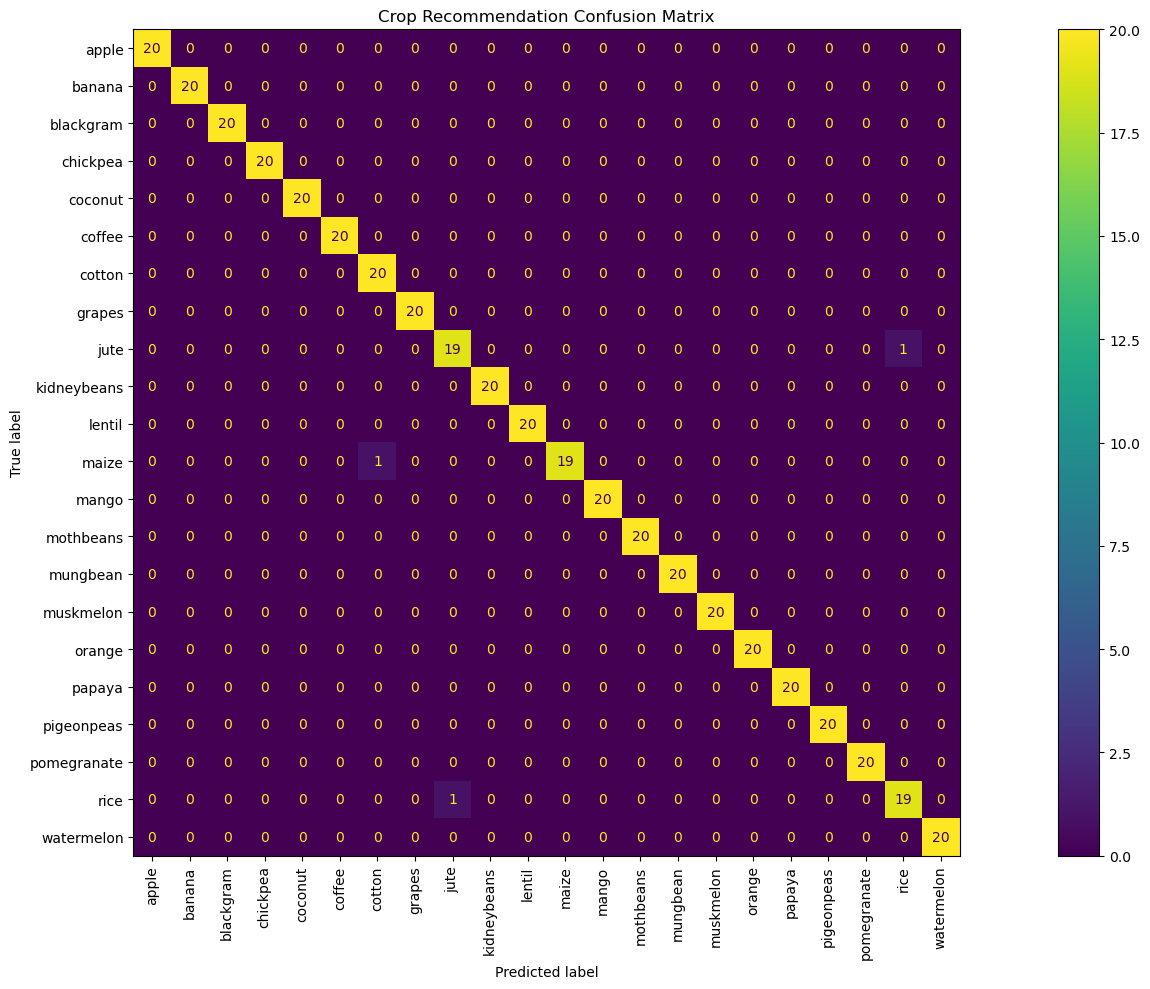

In [30]:
cm = confusion_matrix(y_true_numpy, y_pred_numpy)
matrix = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = label.classes_ )
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
matrix.plot(ax = ax)
plt.setp(ax.get_xticklabels(), rotation = 90)
ax.set_title('Crop Recommendation Confusion Matrix')
plt.tight_layout()
plt.show()


In [31]:
data = {
    'N': [90, 42, 60, 75, 85, 55, 68, 40, 77, 92],
    'P': [42, 55, 30, 48, 52, 38, 45, 60, 41, 50],
    'K': [43, 60, 32, 47, 45, 35, 39, 50, 48, 55],
    'temperature': [26.5, 29.1, 23.8, 28.0, 27.5, 25.6, 30.2, 24.8, 26.9, 29.5],
    'humidity': [82, 70, 88, 75, 80, 72, 85, 77, 83, 78],
    'ph': [6.5, 5.8, 6.9, 6.3, 6.7, 6.1, 5.9, 6.4, 6.6, 6.2],
    'rainfall': [205.3, 120.5, 250.8, 180.2, 195.7, 160.3, 210.4, 175.8, 200.9, 190.0]
}
df_data = pd.DataFrame(data)
df_data

,N,P,K,temperature,humidity,ph,rainfall
0,90,42,43,26.5,82,6.5,205.3
1,42,55,60,29.1,70,5.8,120.5
2,60,30,32,23.8,88,6.9,250.8
3,75,48,47,28.0,75,6.3,180.2
4,85,52,45,27.5,80,6.7,195.7
5,55,38,35,25.6,72,6.1,160.3
6,68,45,39,30.2,85,5.9,210.4
7,40,60,50,24.8,77,6.4,175.8
8,77,41,48,26.9,83,6.6,200.9
9,92,50,55,29.5,78,6.2,190.0


In [32]:
x = df_data.values
x_scaled = scaler.transform(x)  # Transform the data
input_tensor = torch.FloatTensor(x_scaled)  # Use the SCALED data
result = model(input_tensor)
pred_idx = result.argmax(dim = 1)
pred_class = label.inverse_transform(pred_idx.numpy())
print(f'The predicted crop is: {pred_class}')

The predicted crop is: ['rice' 'pigeonpeas' 'rice' 'jute' 'rice' 'jute' 'rice' 'pigeonpeas'
 'rice' 'rice']


In [33]:
# save Minmaxscaler
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [34]:
# save LabelEncoder
joblib.dump(label, 'le.pkl')


['le.pkl']

# SHAP ANALYSIS

In [35]:
feature_names = feature_names
num_classes = len(label.classes_)

In [36]:
# Use a small background sample for efficiency
background = X_train_scale[:100].astype(np.float32)
# Model prediction wrapper
def predict_numpy(x: np.ndarray) -> np.ndarray:
    model.eval()
    with torch.no_grad():
        x_tensor = torch.from_numpy(x.astype(np.float32))
        probs = F.softmax(model(x_tensor), dim = 1).cpu().numpy()
    return probs

# Create SHAP explainer
explainer = shap.Explainer(predict_numpy, shap.maskers.Independent(background))
shap_values = explainer(X_test_scale.astype(np.float32))

# Normalize SHAP output structure
vals = shap_values.values
if isinstance(vals, list):
    class_shap = vals
elif vals.ndim == 3:  
    class_shap = [vals[:, :, i] for i in range(vals.shape[2])]
else:
    class_shap = [vals]

print(f"SHAP ready ✓ Classes: {num_classes} | Shape per class: {class_shap[0].shape}")


ExactExplainer explainer: 441it [00:15, 28.64it/s]                                                                     

SHAP ready ✓ Classes: 22 | Shape per class: (440, 7)


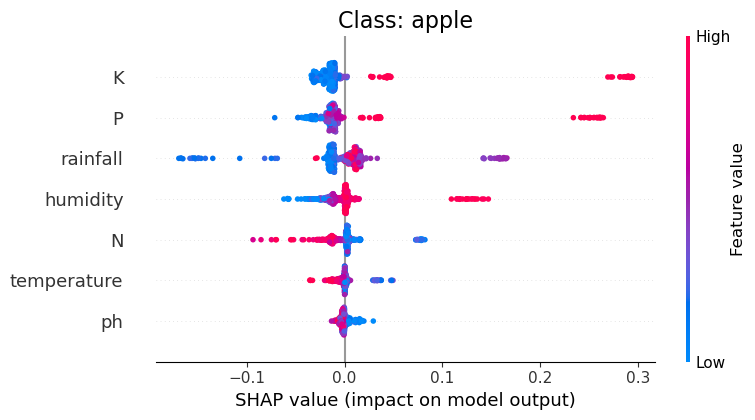

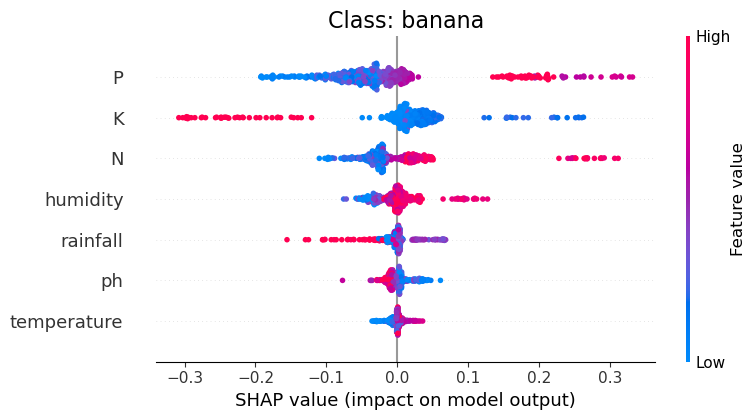

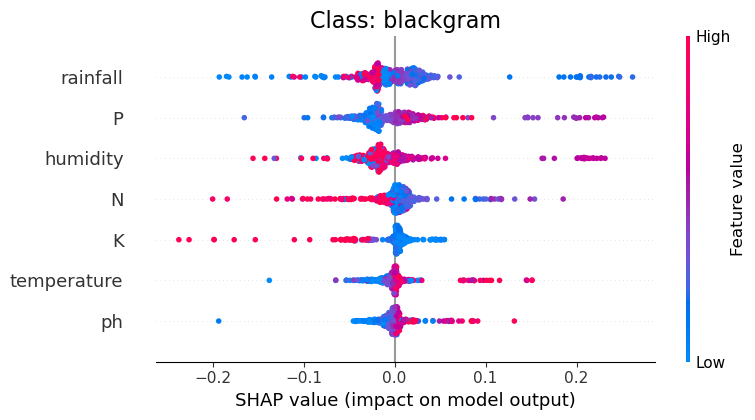

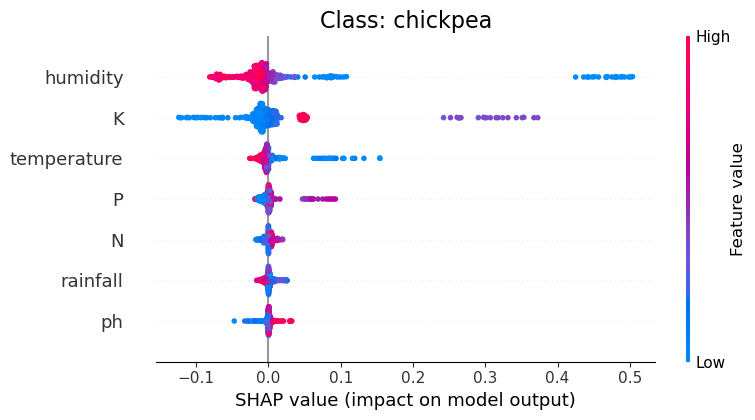

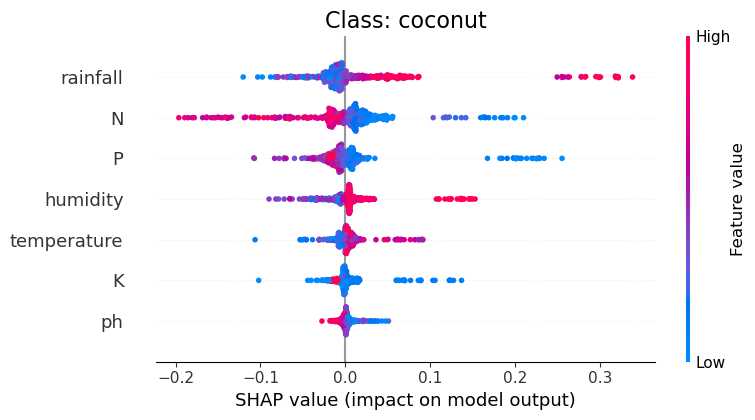

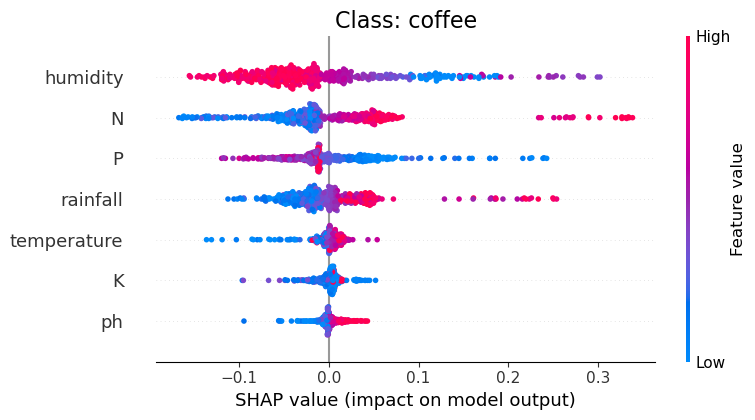

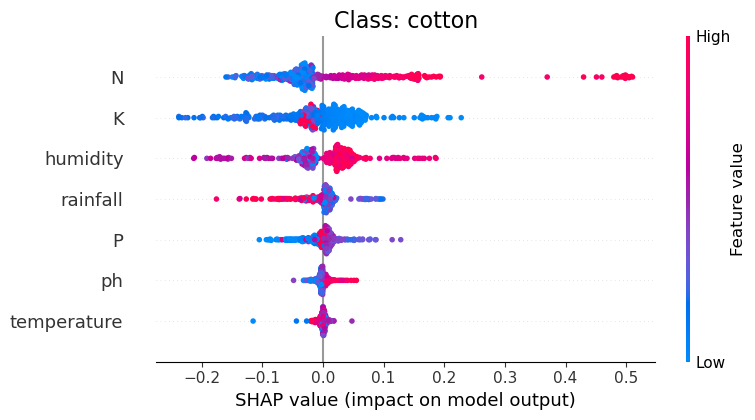

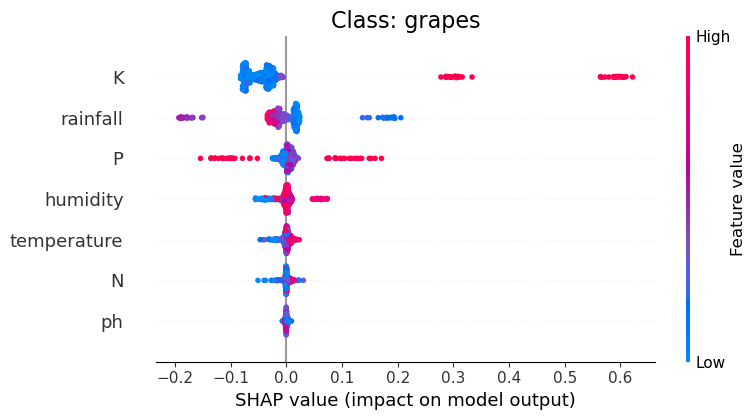

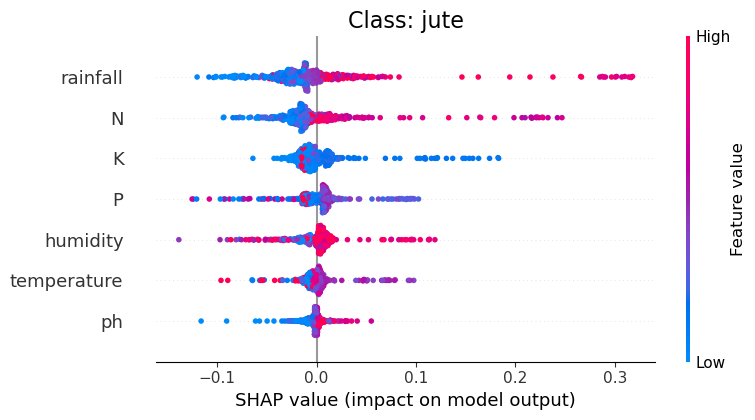

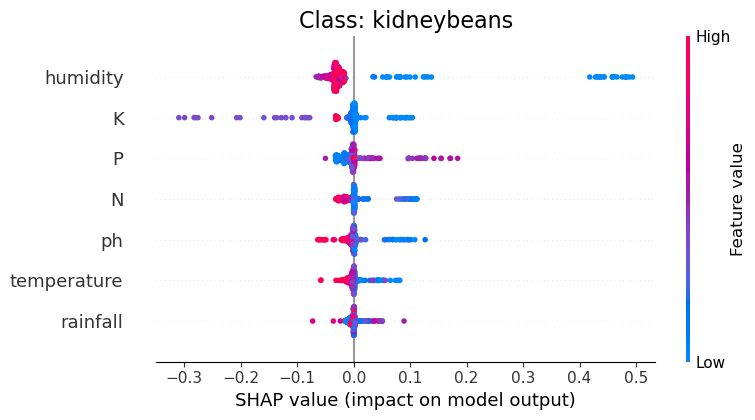

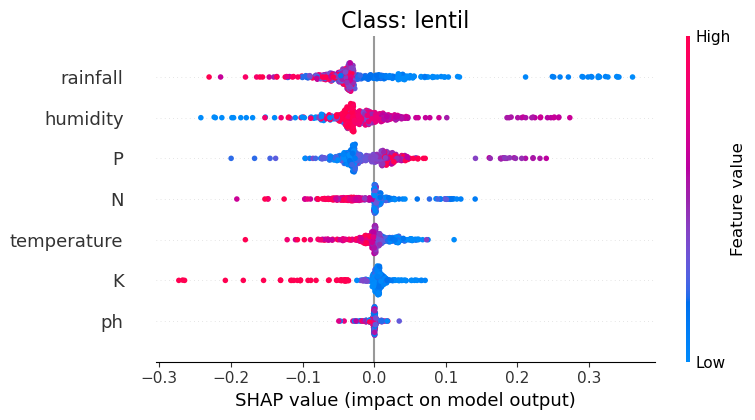

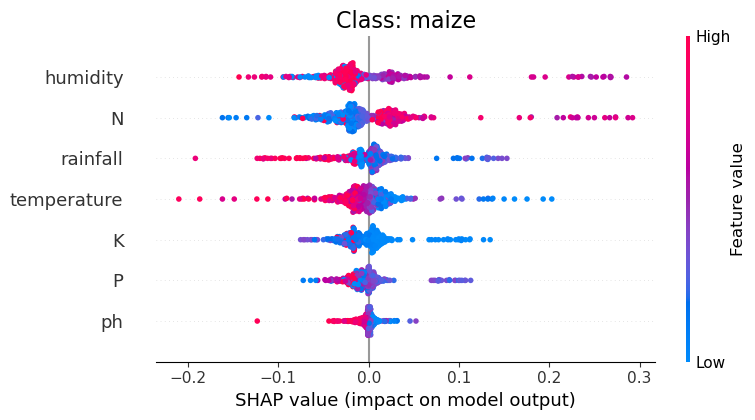

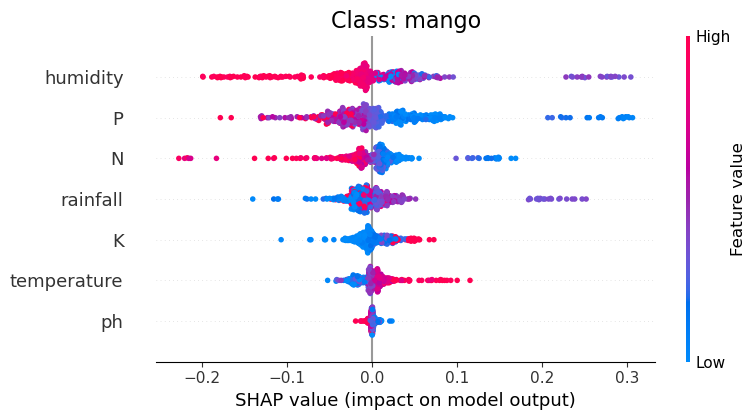

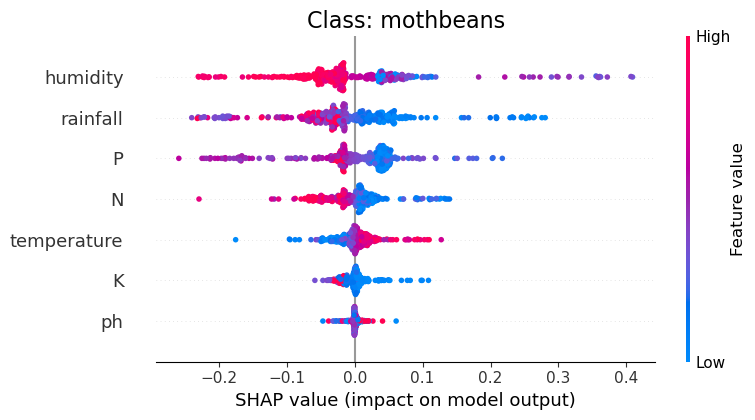

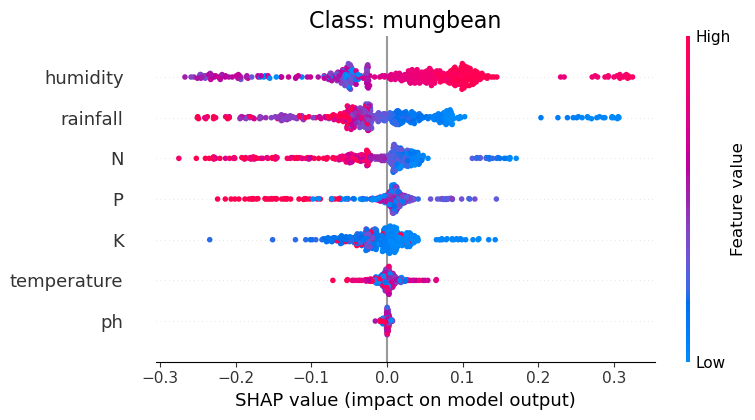

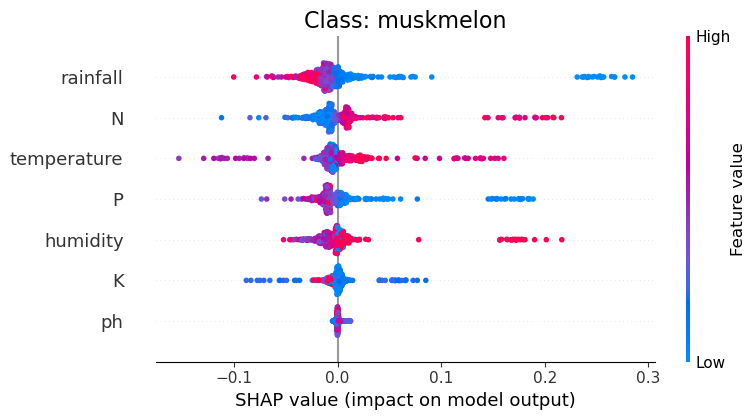

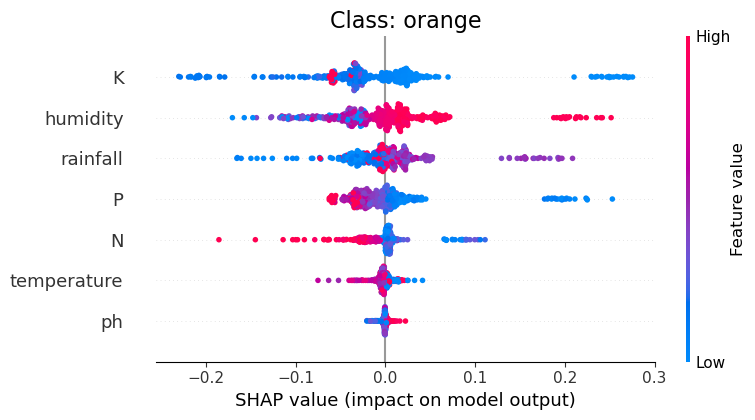

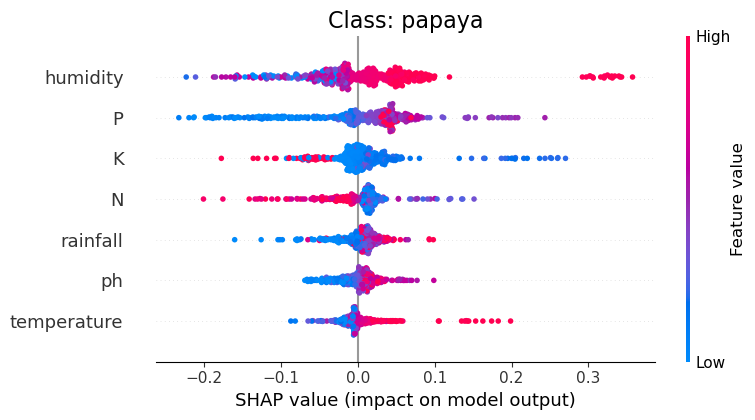

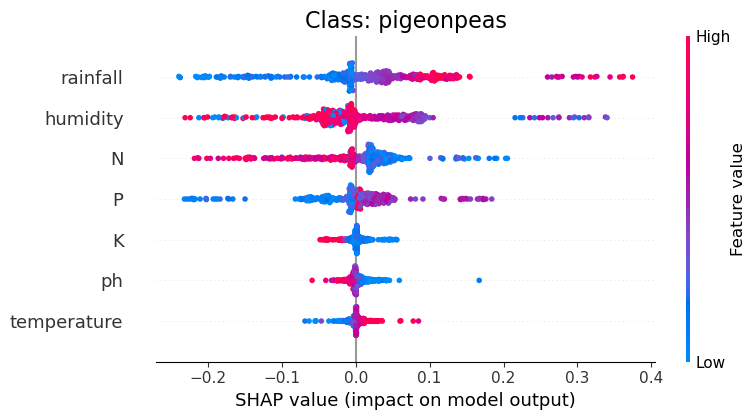

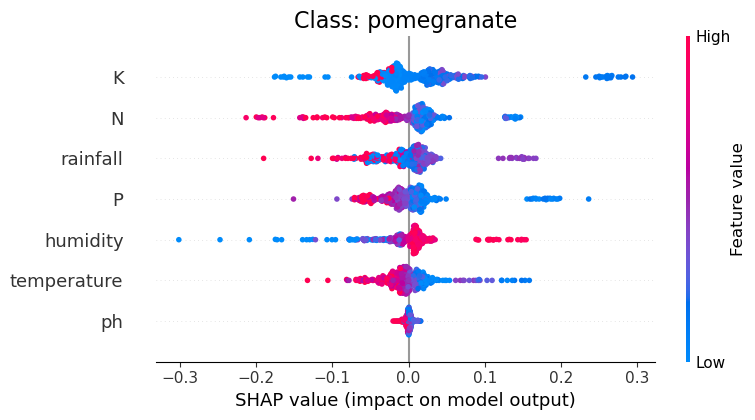

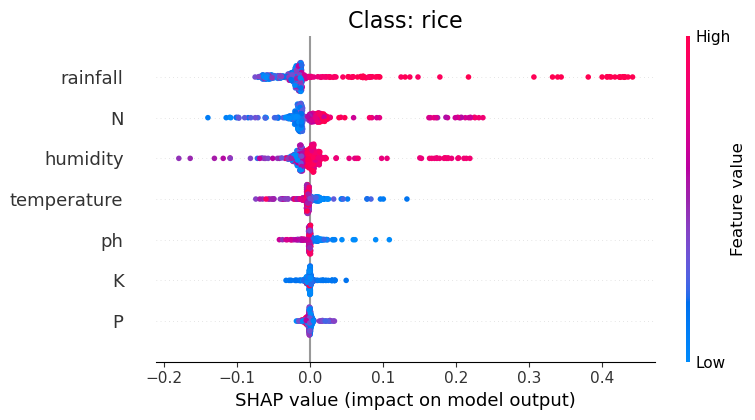

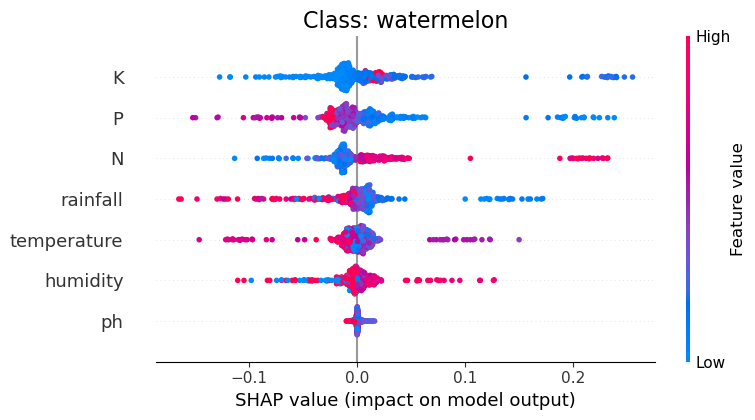

In [37]:
# Make sure X_test_df has the right column names
X_test_df = pd.DataFrame(X_test_scale, columns = feature_names)

def plot_shap_summaries():
    for idx, values in enumerate(class_shap):
        plt.figure(figsize = (10, 8))
        shap.summary_plot(
            values,
            X_test_df,  # <- pass the DataFrame here
            show = False,
            max_display = min(20, len(feature_names))
        )
        plt.title(f"Class: {label.classes_[idx]}", fontsize=16)
        plt.tight_layout()
        plt.show()

plot_shap_summaries()


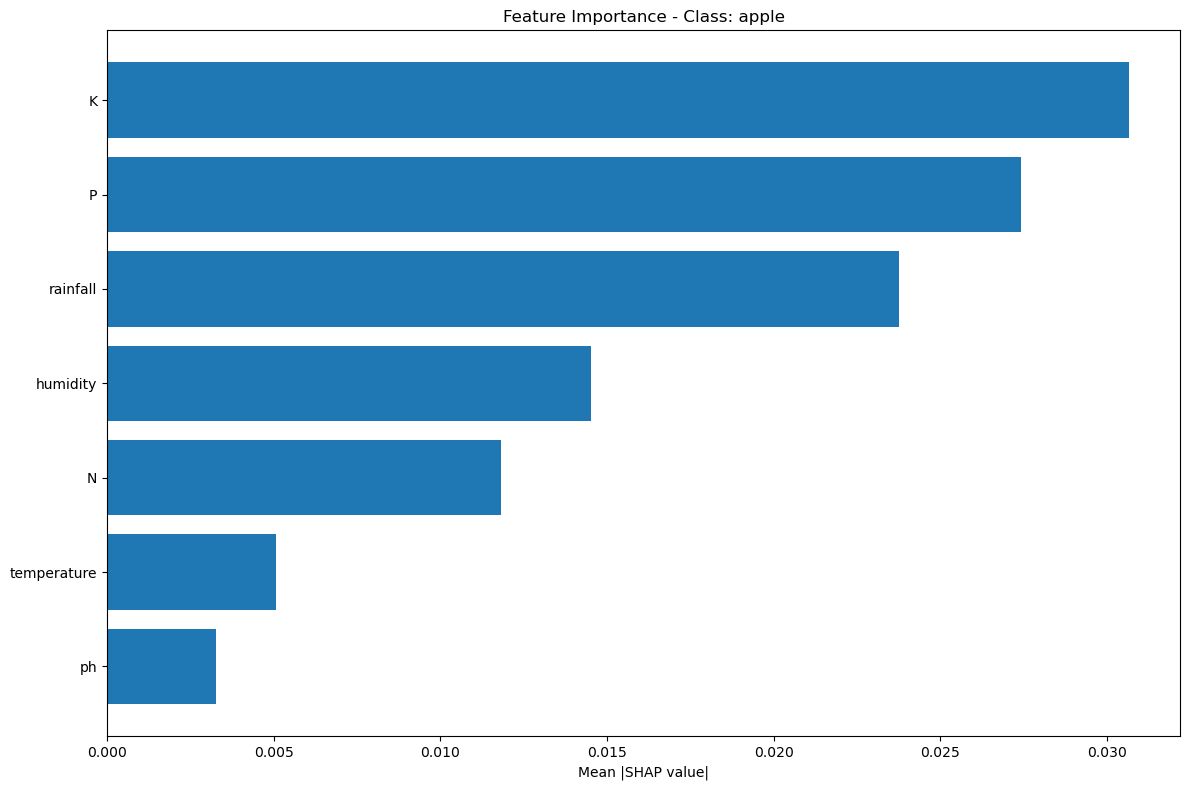


Top 10 important features for class 'apple':
  ph: 0.003262
  temperature: 0.005066
  N: 0.011828
  humidity: 0.014510
  rainfall: 0.023761
  P: 0.027428
  K: 0.030658


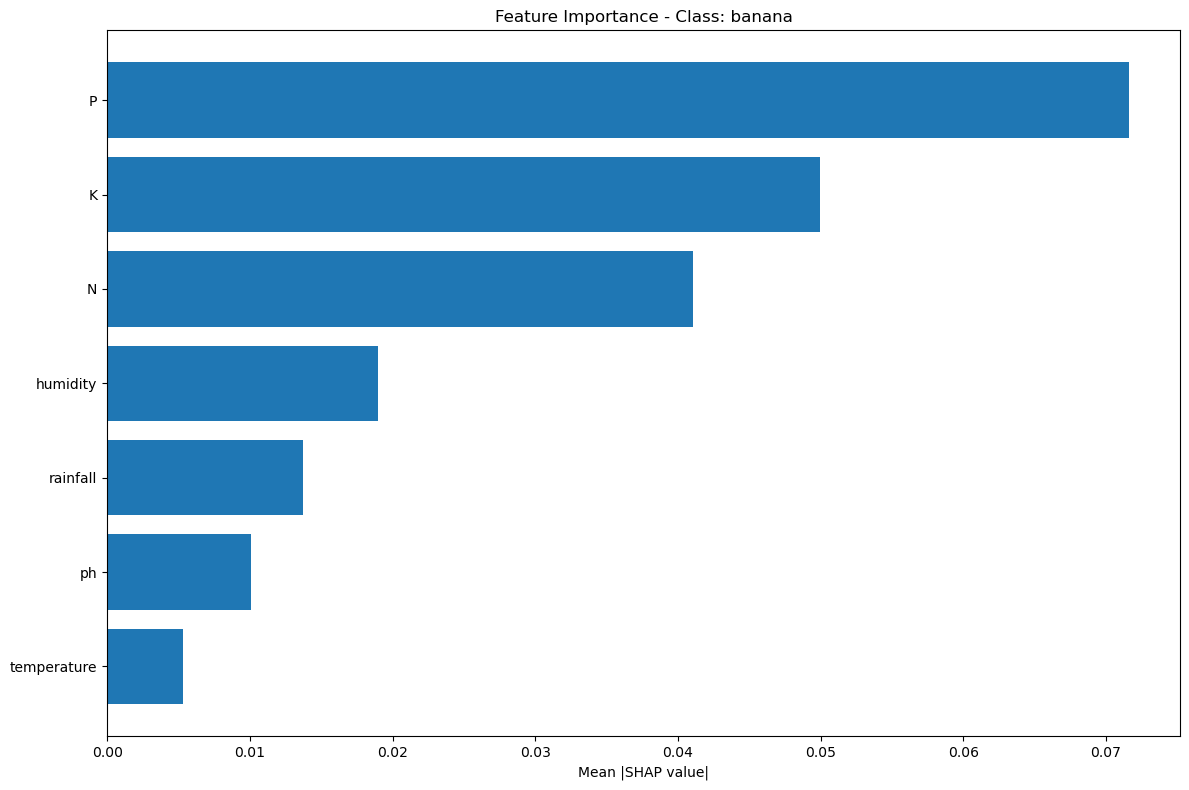


Top 10 important features for class 'banana':
  temperature: 0.005340
  ph: 0.010090
  rainfall: 0.013717
  humidity: 0.019014
  N: 0.041041
  K: 0.049954
  P: 0.071612


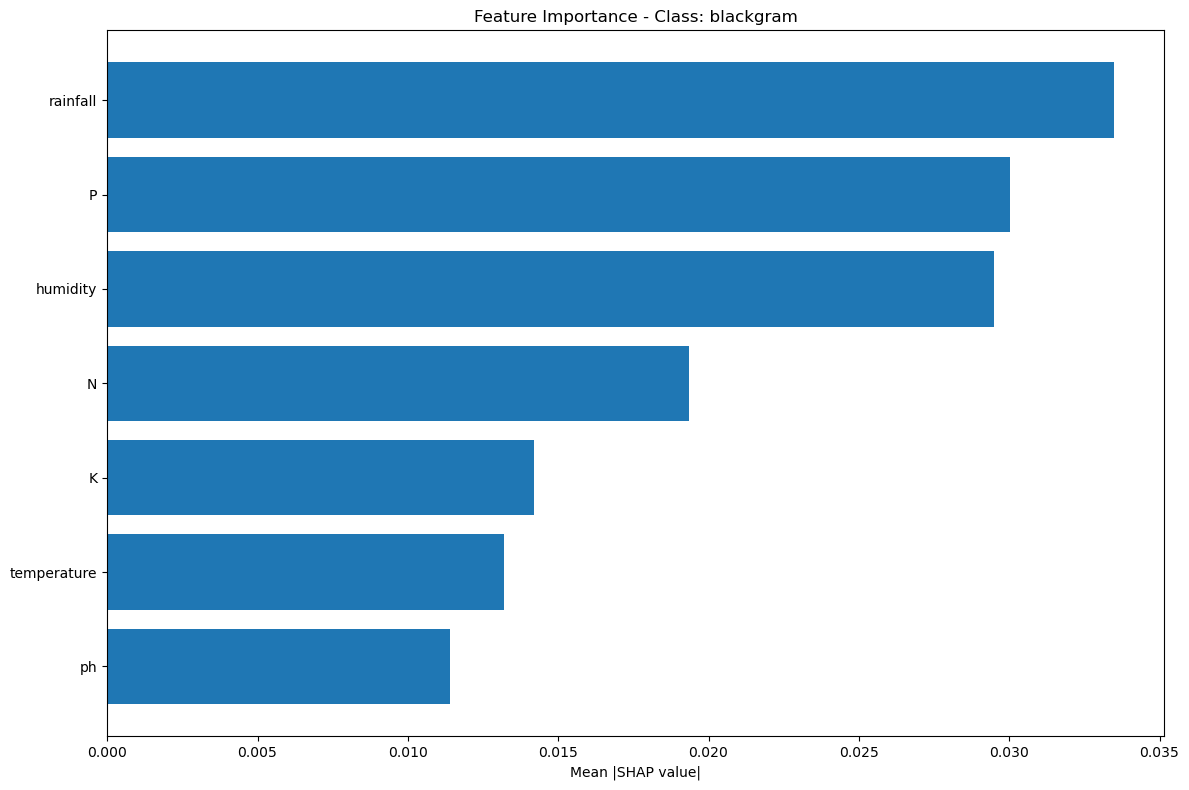


Top 10 important features for class 'blackgram':
  ph: 0.011390
  temperature: 0.013214
  K: 0.014211
  N: 0.019353
  humidity: 0.029480
  P: 0.030035
  rainfall: 0.033481


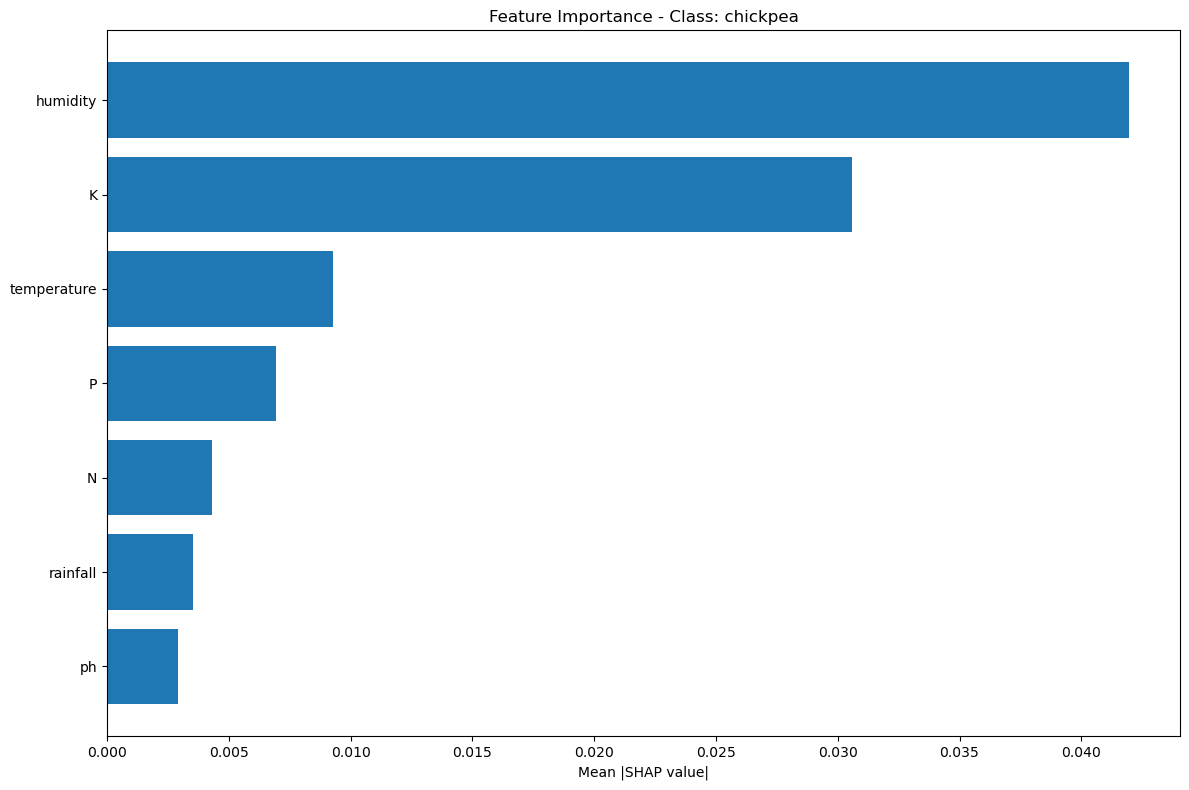


Top 10 important features for class 'chickpea':
  ph: 0.002917
  rainfall: 0.003503
  N: 0.004299
  P: 0.006922
  temperature: 0.009271
  K: 0.030595
  humidity: 0.041957


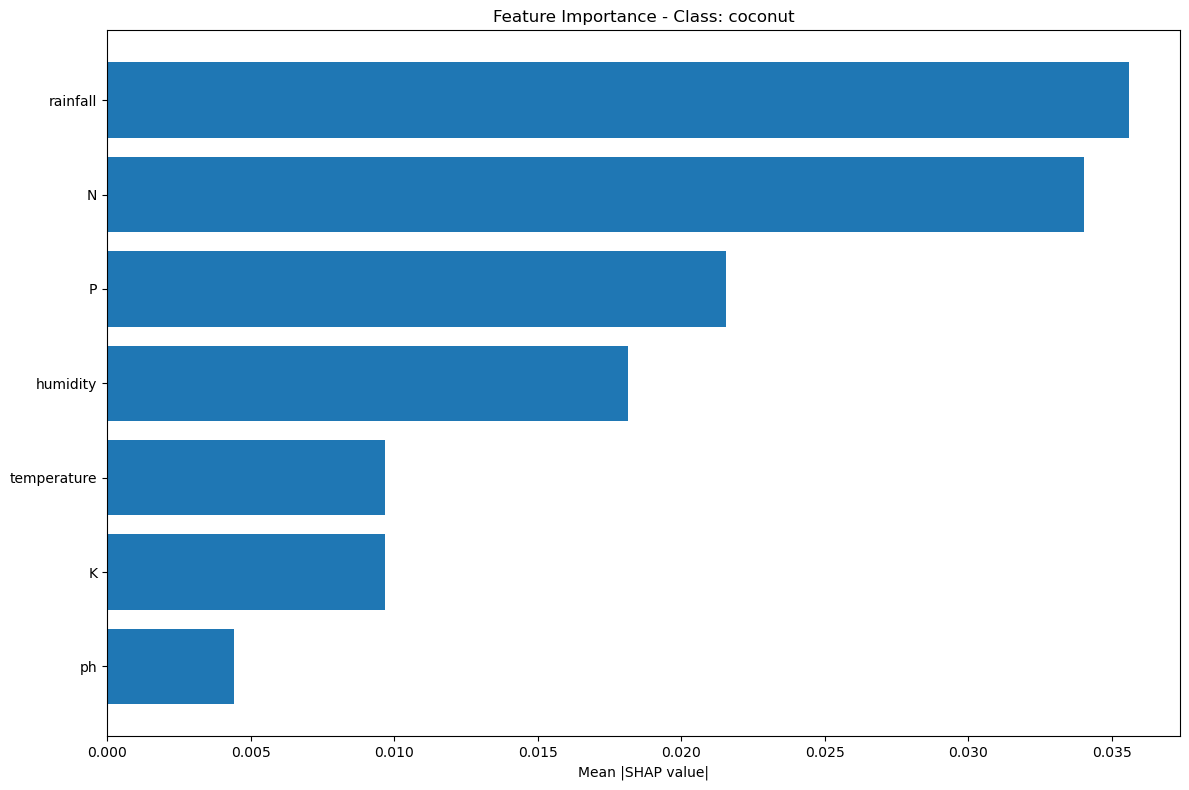


Top 10 important features for class 'coconut':
  ph: 0.004418
  K: 0.009685
  temperature: 0.009696
  humidity: 0.018134
  P: 0.021571
  N: 0.034055
  rainfall: 0.035605


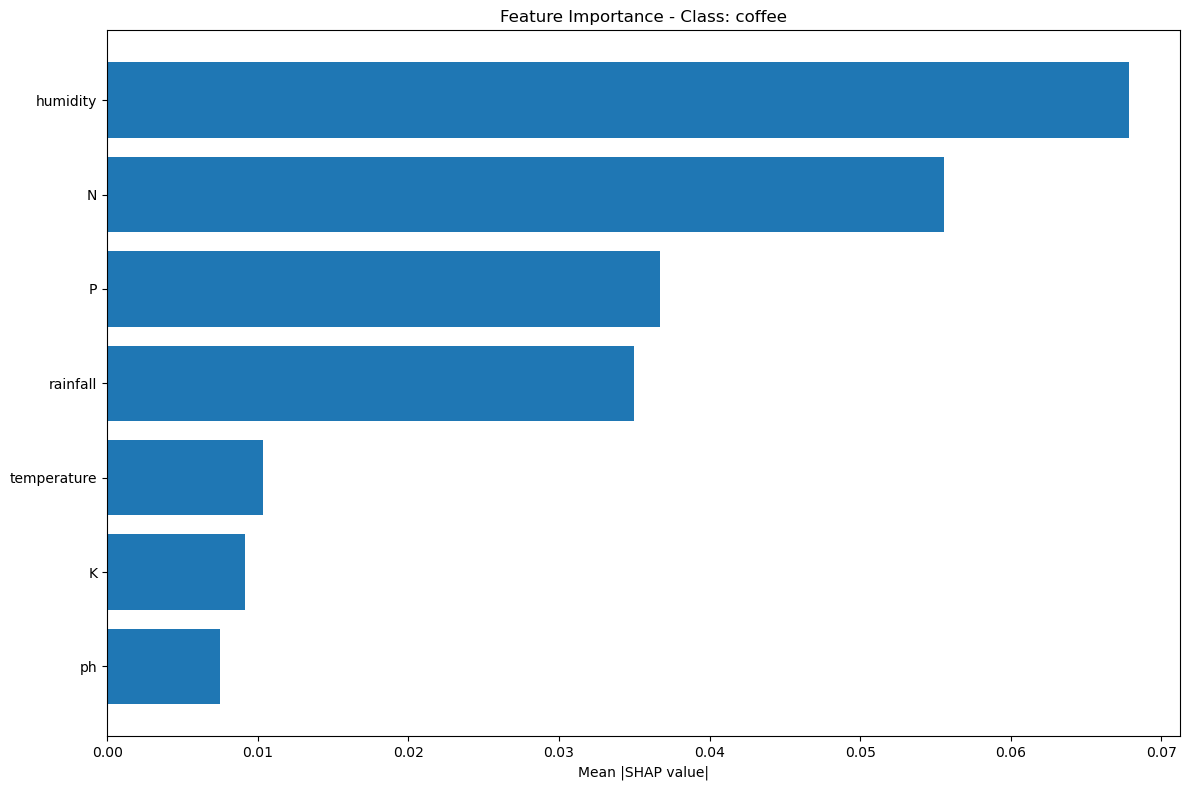


Top 10 important features for class 'coffee':
  ph: 0.007498
  K: 0.009133
  temperature: 0.010358
  rainfall: 0.034949
  P: 0.036738
  N: 0.055563
  humidity: 0.067841


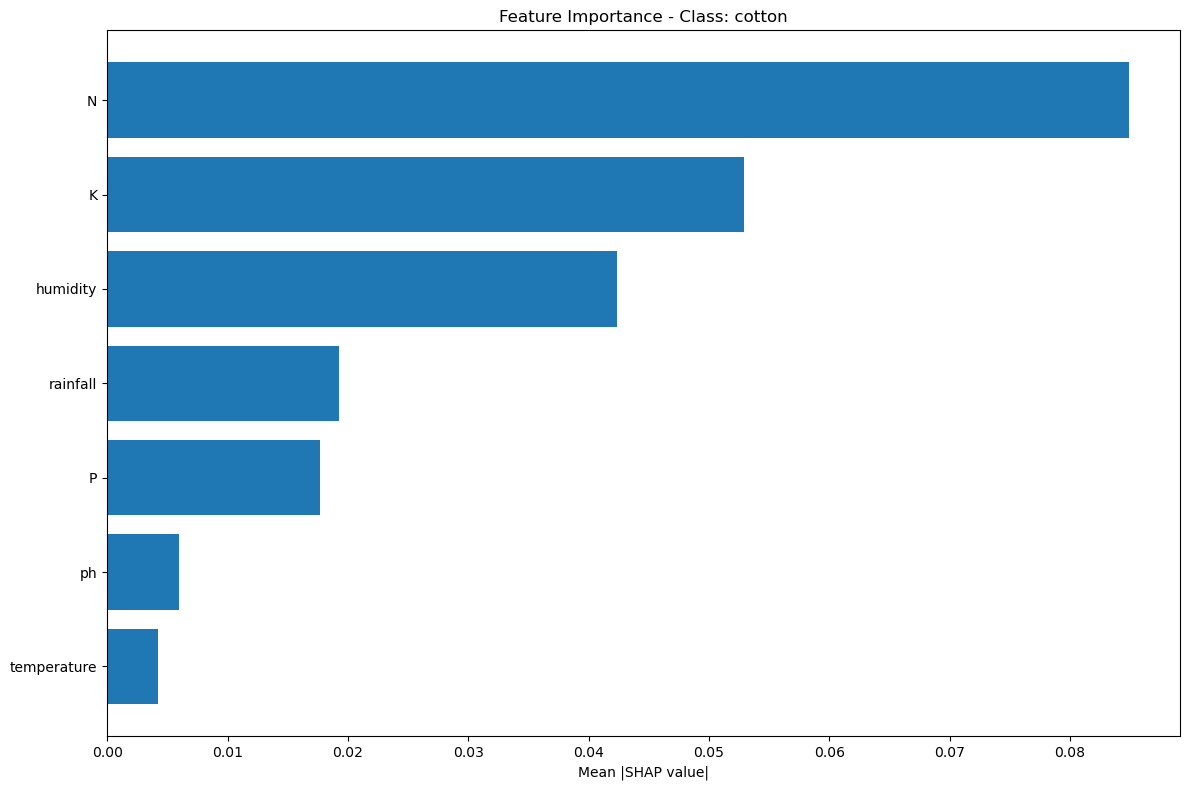


Top 10 important features for class 'cotton':
  temperature: 0.004198
  ph: 0.005970
  P: 0.017716
  rainfall: 0.019283
  humidity: 0.042328
  K: 0.052925
  N: 0.084885


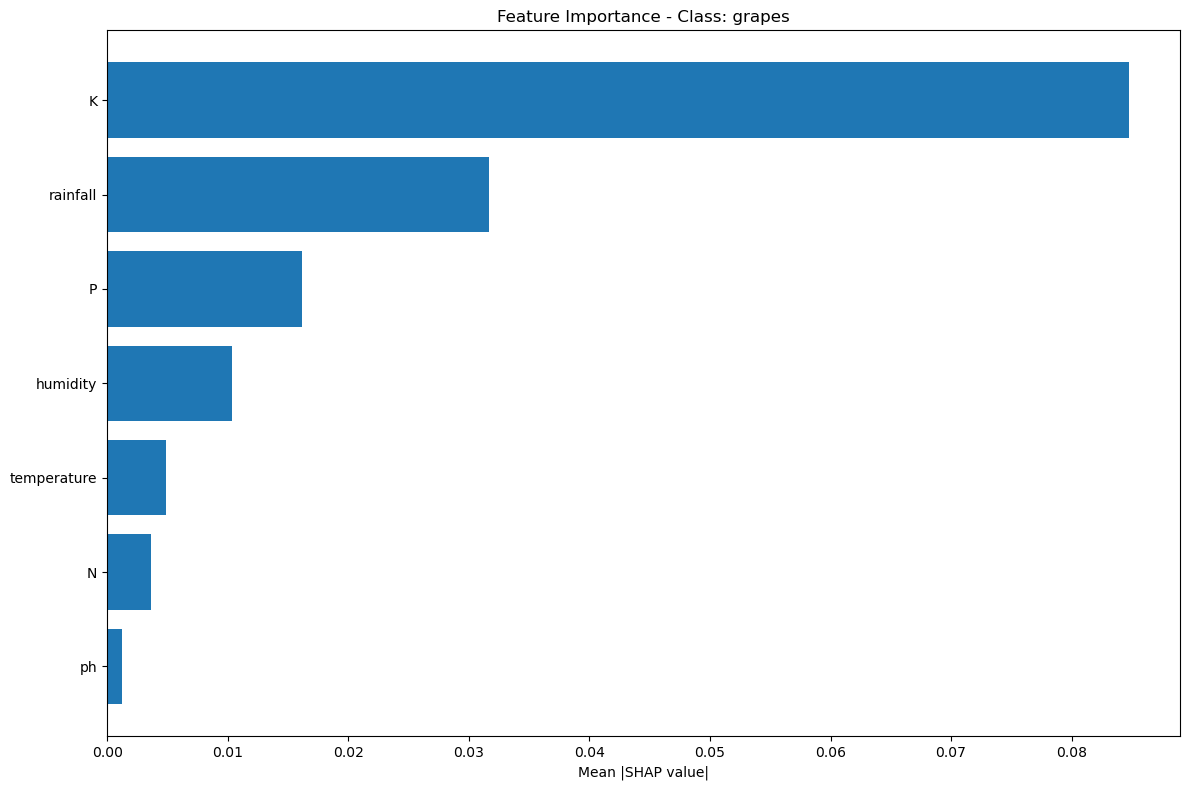


Top 10 important features for class 'grapes':
  ph: 0.001211
  N: 0.003646
  temperature: 0.004906
  humidity: 0.010336
  P: 0.016164
  rainfall: 0.031694
  K: 0.084755


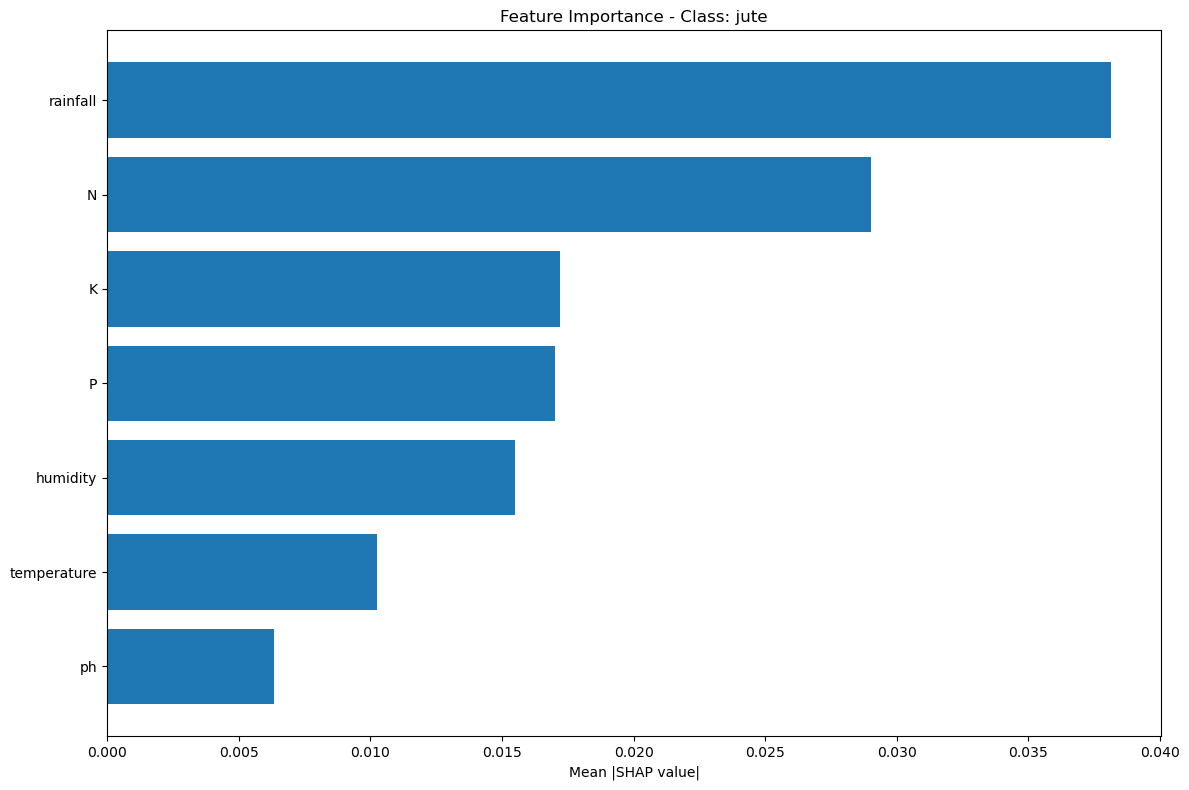


Top 10 important features for class 'jute':
  ph: 0.006341
  temperature: 0.010259
  humidity: 0.015507
  P: 0.017005
  K: 0.017194
  N: 0.029006
  rainfall: 0.038137


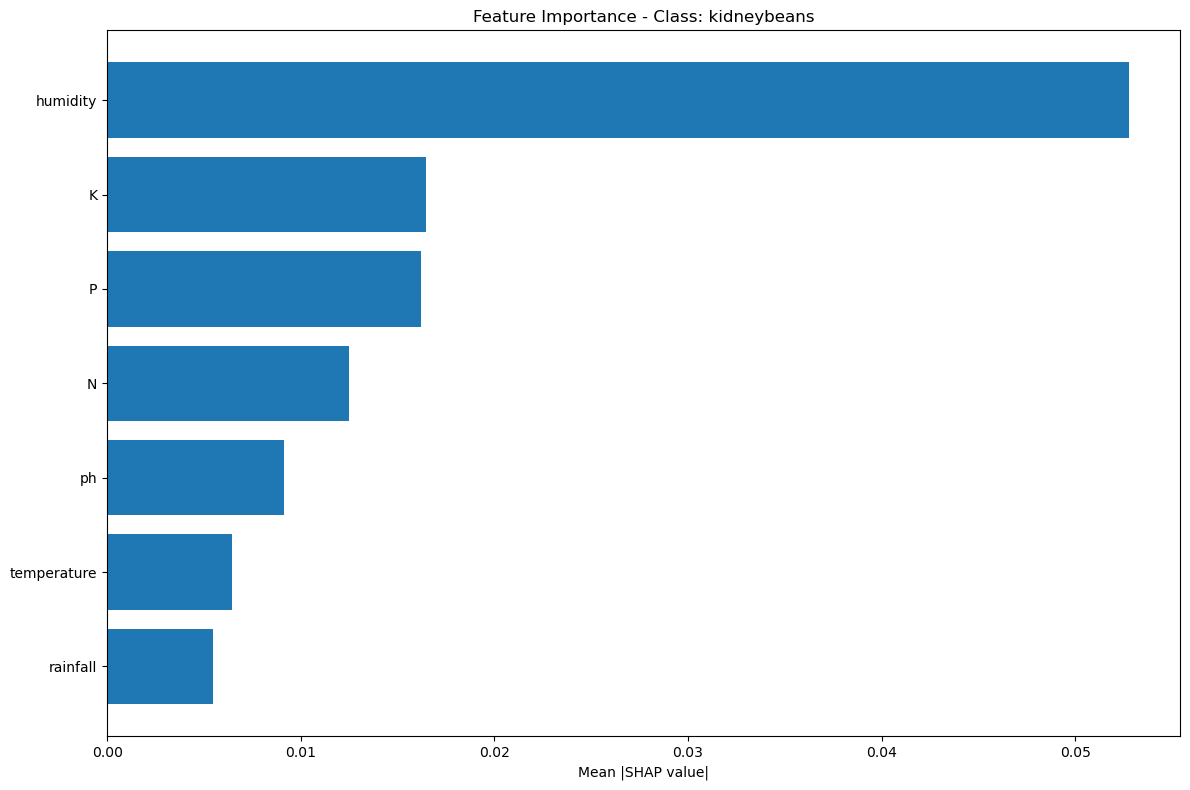


Top 10 important features for class 'kidneybeans':
  rainfall: 0.005445
  temperature: 0.006467
  ph: 0.009125
  N: 0.012479
  P: 0.016229
  K: 0.016484
  humidity: 0.052776


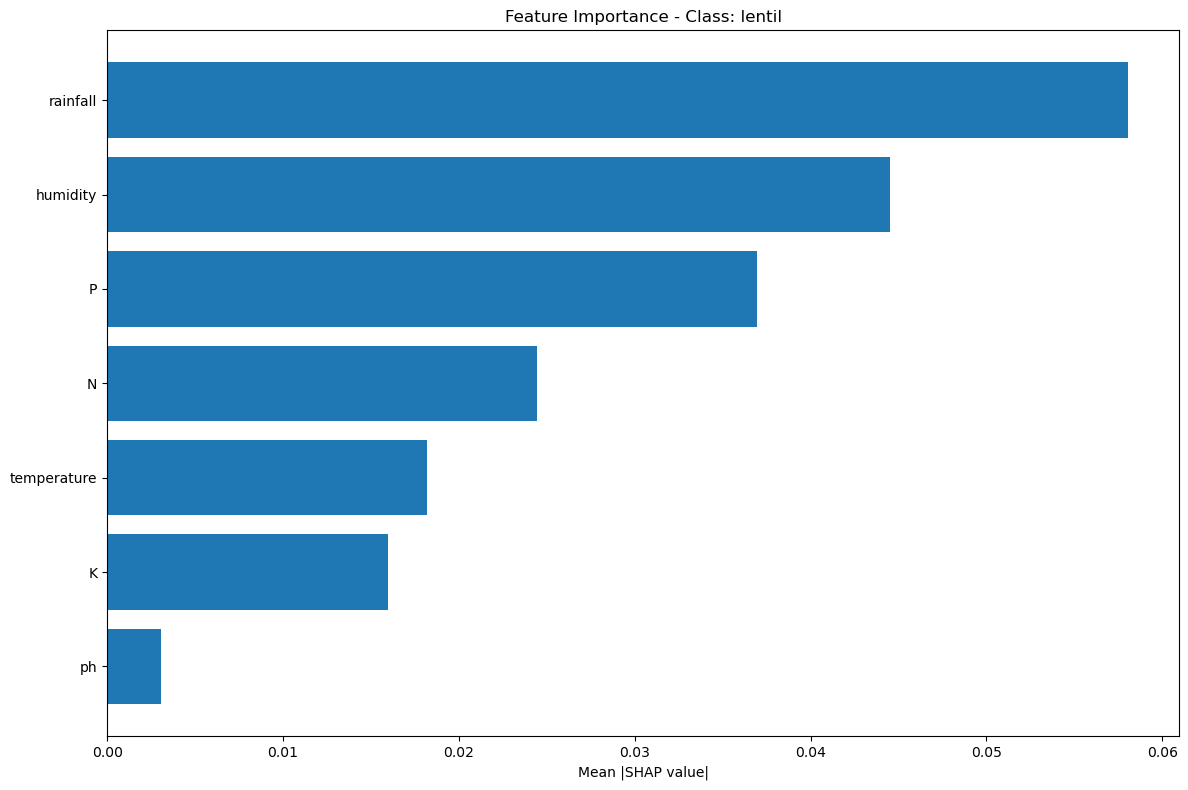


Top 10 important features for class 'lentil':
  ph: 0.003052
  K: 0.015960
  temperature: 0.018212
  N: 0.024425
  P: 0.036946
  humidity: 0.044503
  rainfall: 0.058047


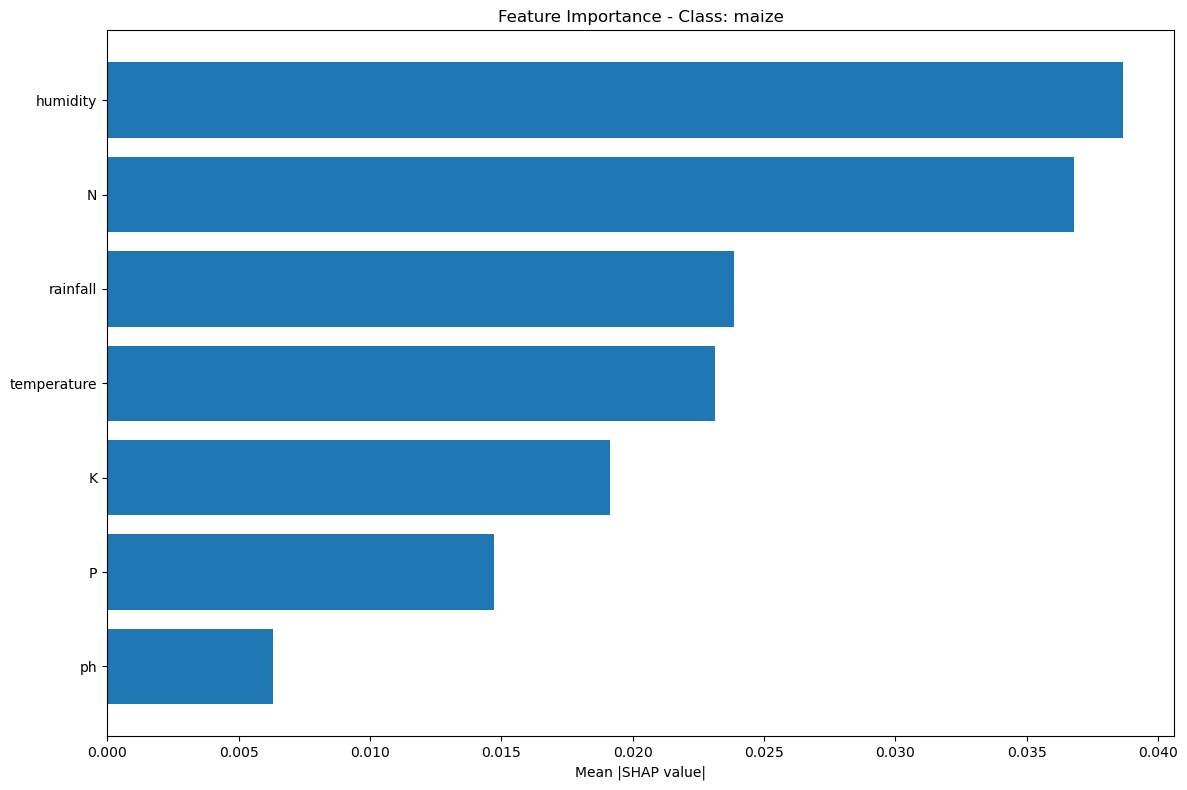


Top 10 important features for class 'maize':
  ph: 0.006295
  P: 0.014719
  K: 0.019140
  temperature: 0.023144
  rainfall: 0.023853
  N: 0.036811
  humidity: 0.038665


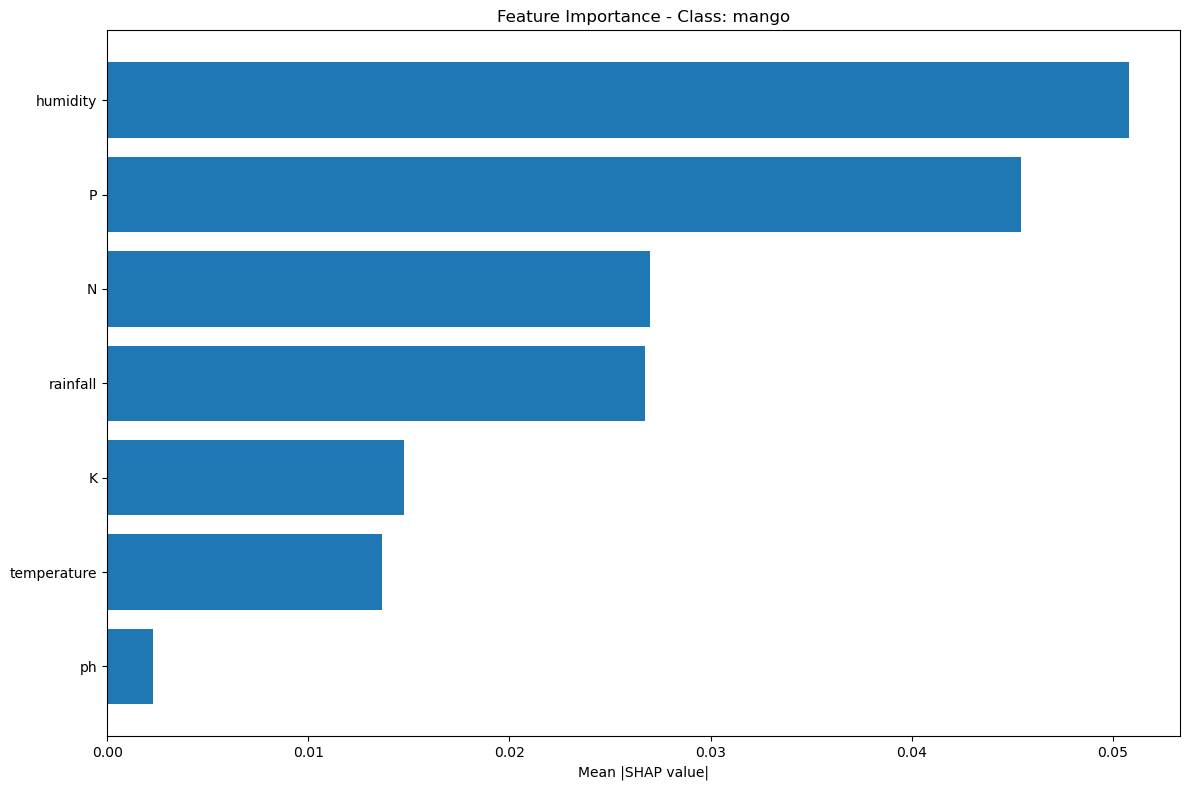


Top 10 important features for class 'mango':
  ph: 0.002287
  temperature: 0.013672
  K: 0.014782
  rainfall: 0.026719
  N: 0.027011
  P: 0.045459
  humidity: 0.050805


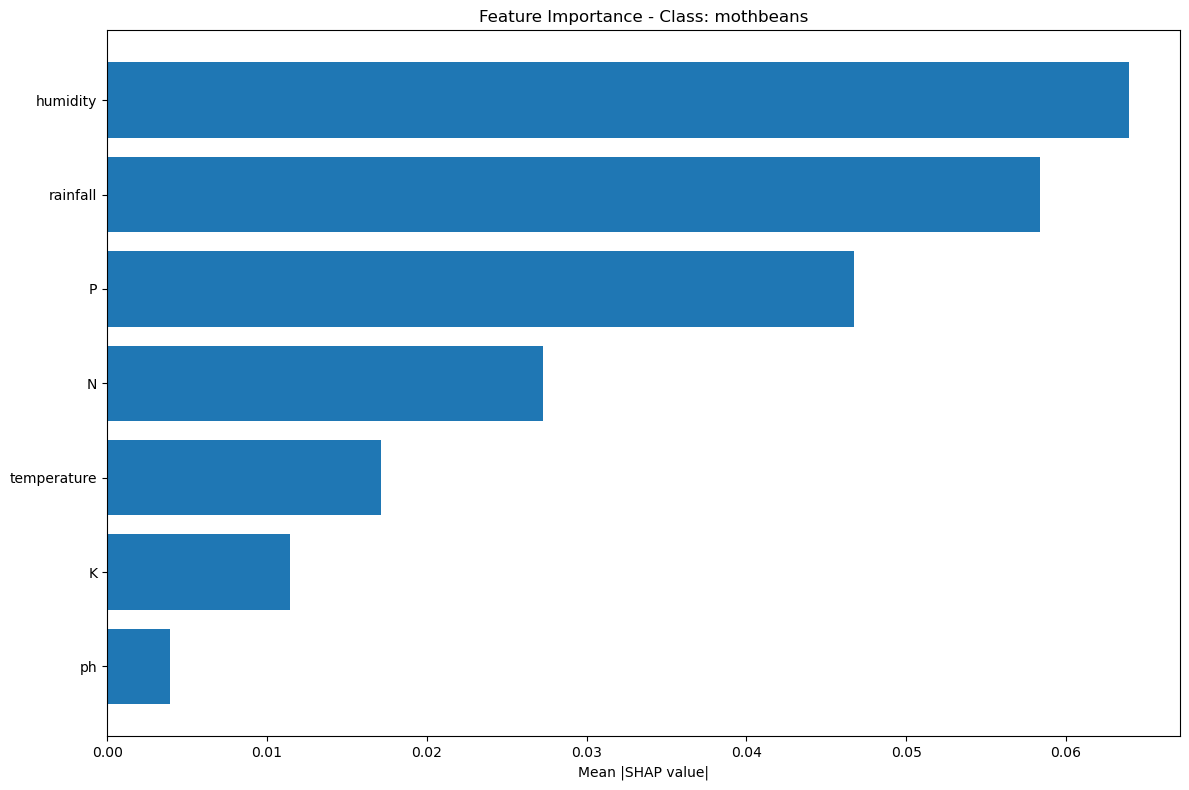


Top 10 important features for class 'mothbeans':
  ph: 0.003952
  K: 0.011458
  temperature: 0.017151
  N: 0.027260
  P: 0.046715
  rainfall: 0.058363
  humidity: 0.063943


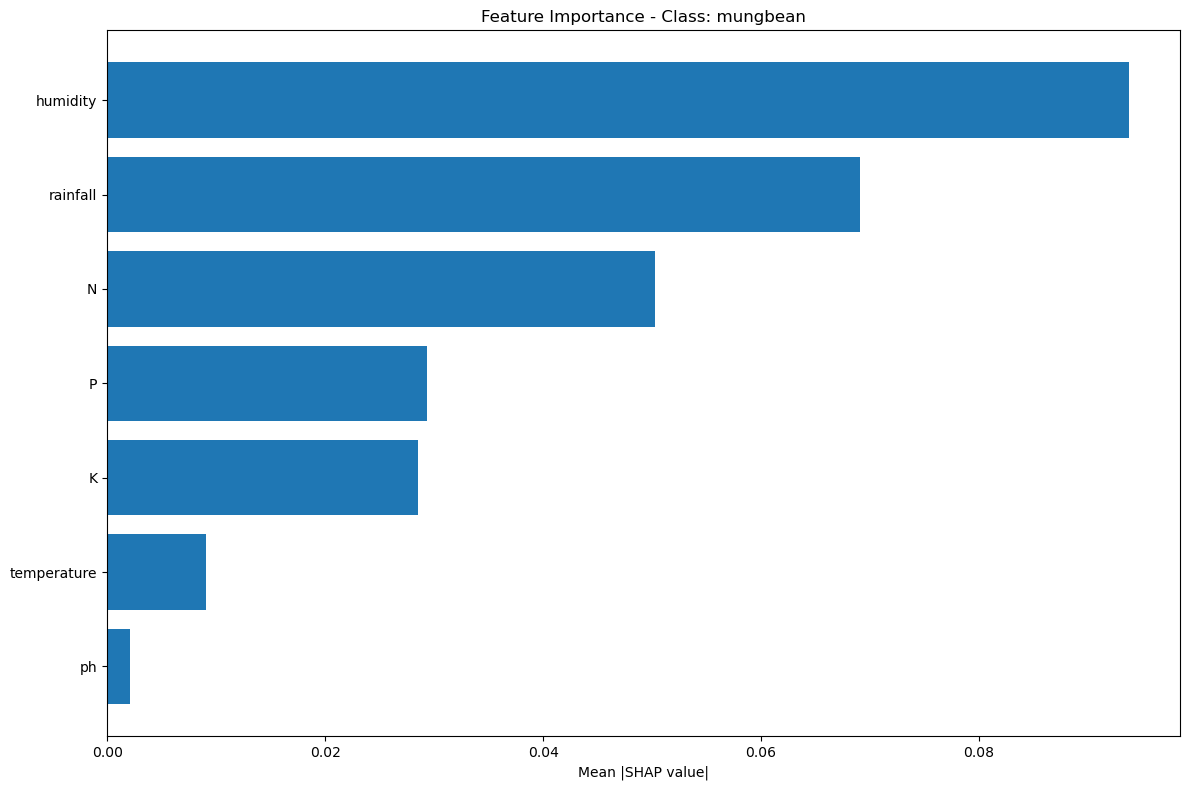


Top 10 important features for class 'mungbean':
  ph: 0.002092
  temperature: 0.009105
  K: 0.028492
  P: 0.029352
  N: 0.050311
  rainfall: 0.069119
  humidity: 0.093753


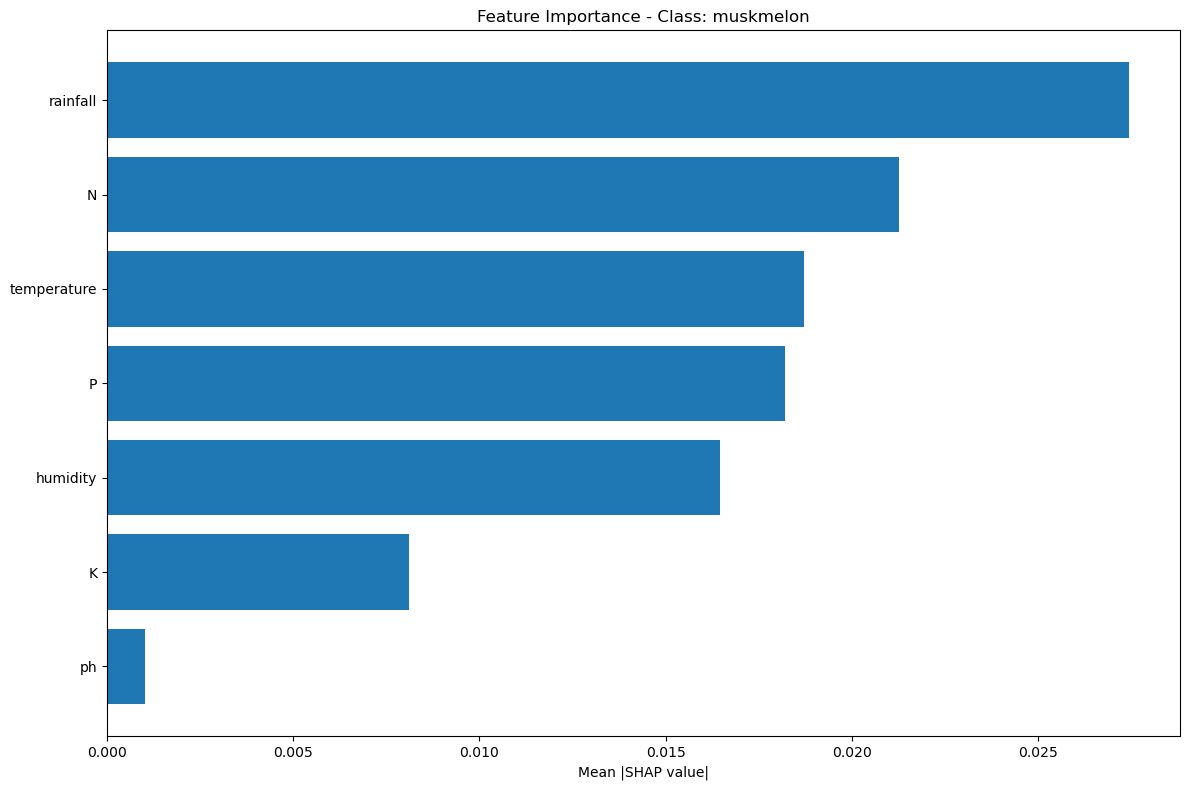


Top 10 important features for class 'muskmelon':
  ph: 0.001024
  K: 0.008104
  humidity: 0.016450
  P: 0.018218
  temperature: 0.018715
  N: 0.021273
  rainfall: 0.027447


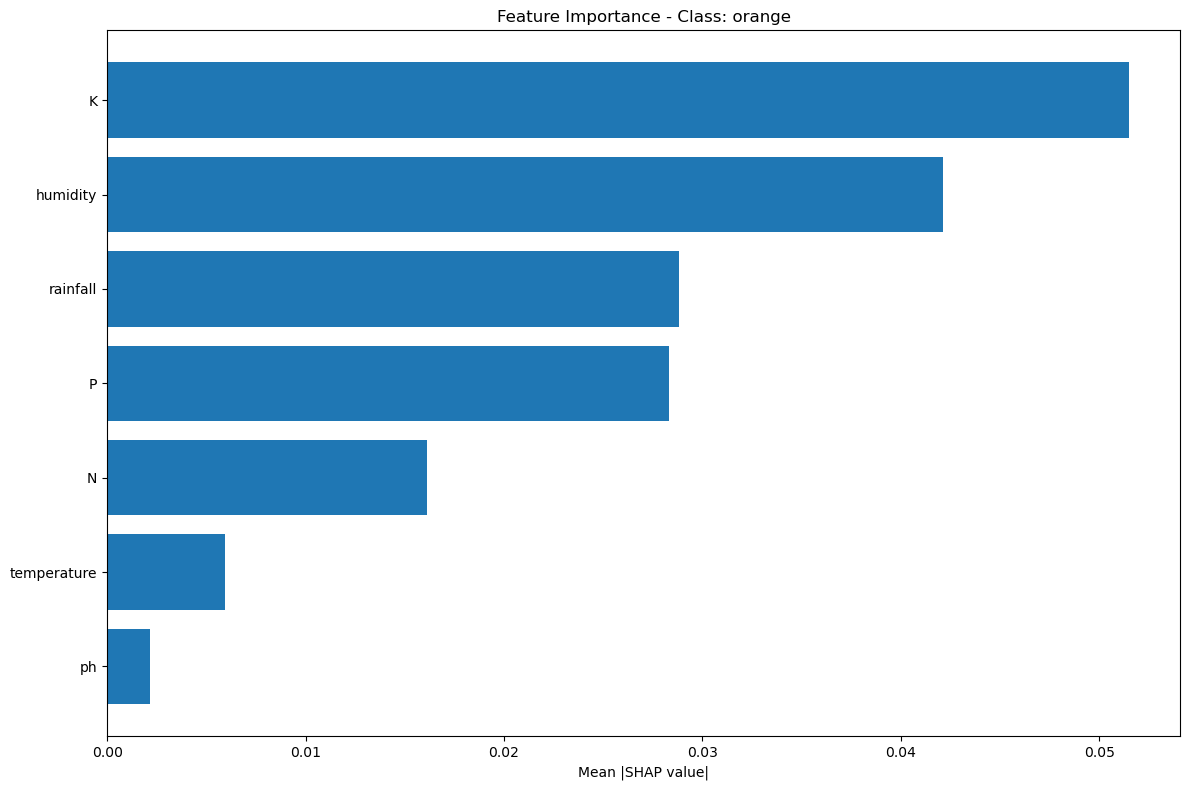


Top 10 important features for class 'orange':
  ph: 0.002176
  temperature: 0.005960
  N: 0.016140
  P: 0.028297
  rainfall: 0.028806
  humidity: 0.042131
  K: 0.051500


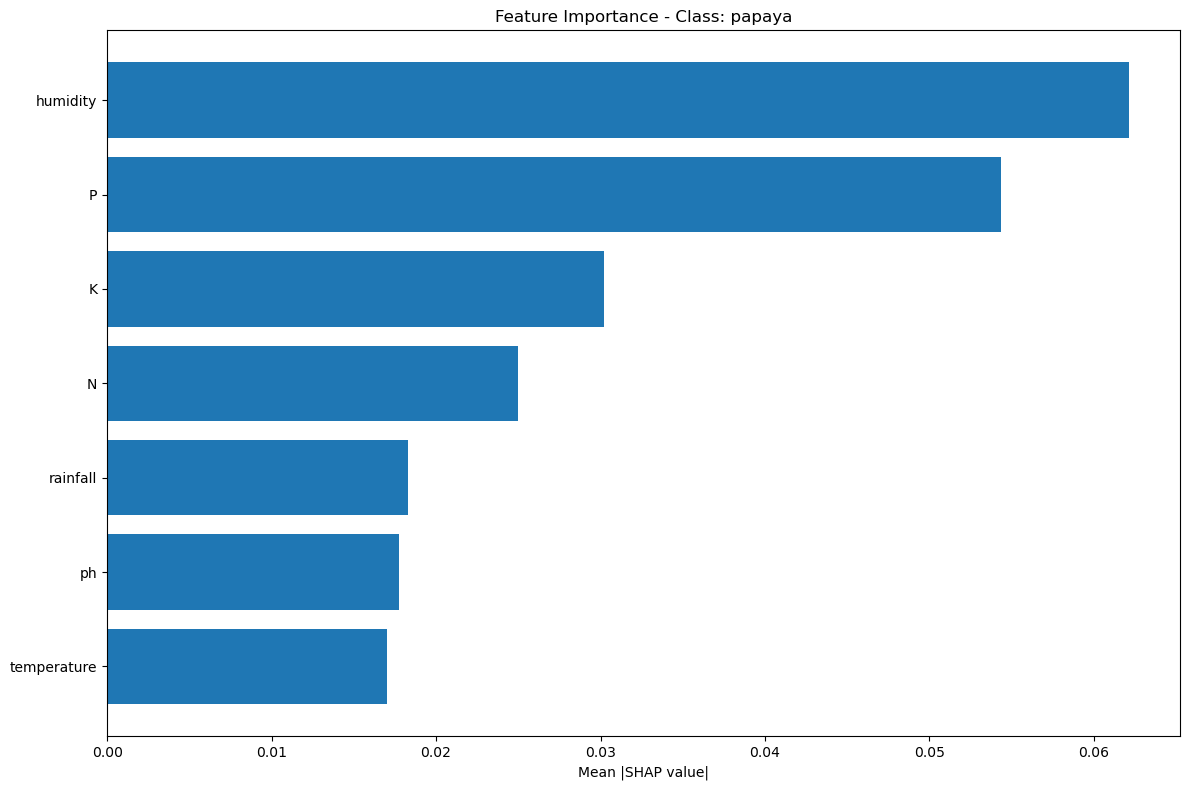


Top 10 important features for class 'papaya':
  temperature: 0.017027
  ph: 0.017746
  rainfall: 0.018278
  N: 0.024983
  K: 0.030205
  P: 0.054344
  humidity: 0.062128


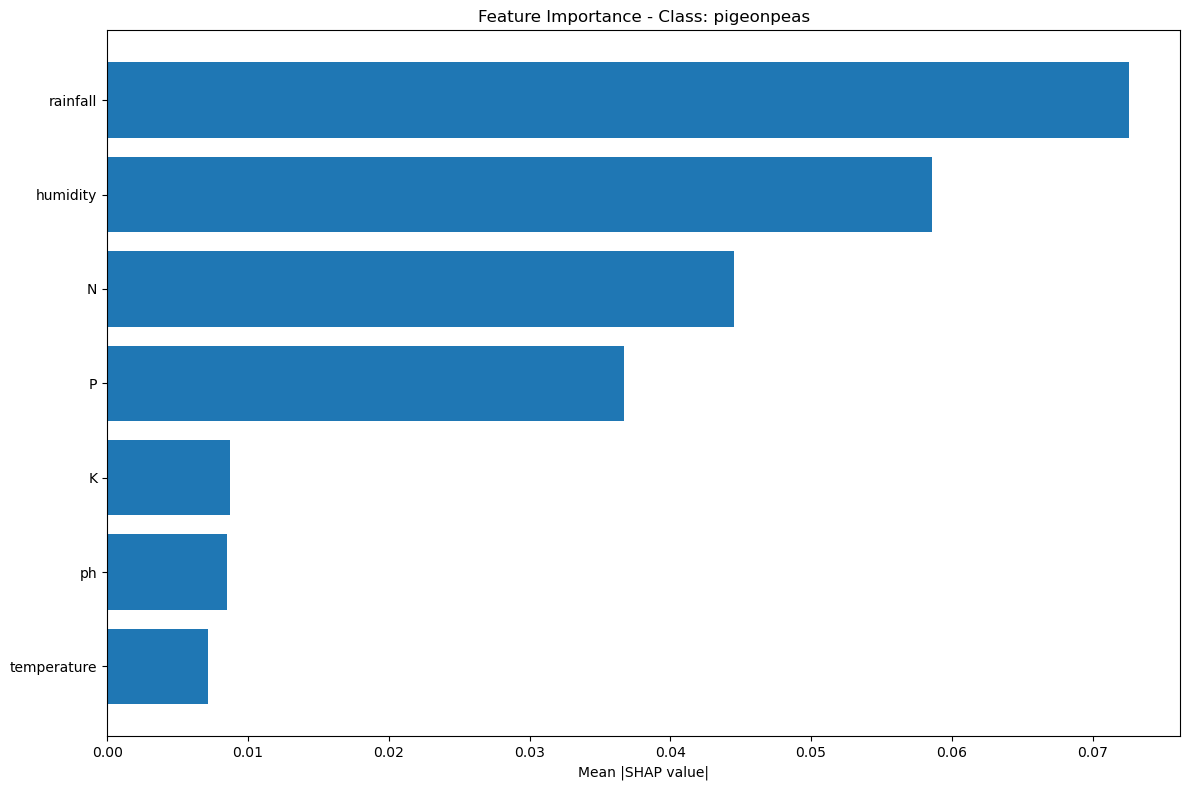


Top 10 important features for class 'pigeonpeas':
  temperature: 0.007191
  ph: 0.008514
  K: 0.008725
  P: 0.036683
  N: 0.044525
  humidity: 0.058624
  rainfall: 0.072583


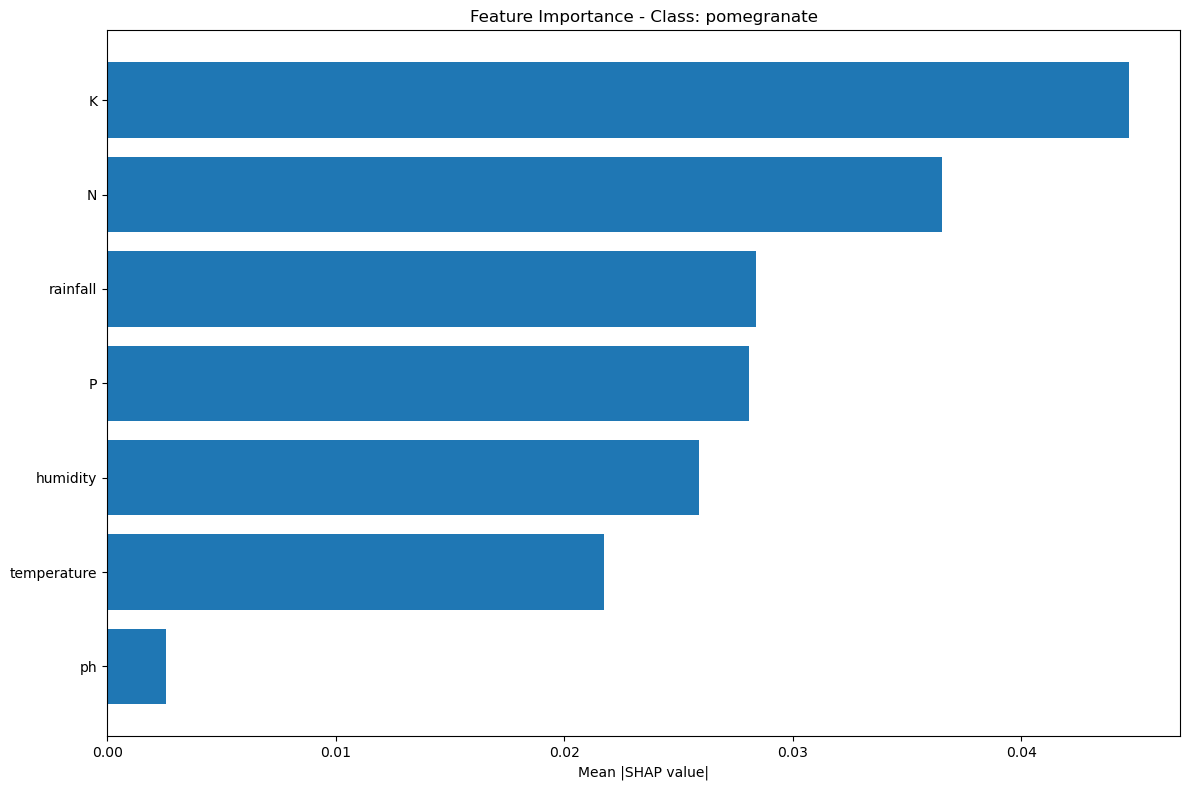


Top 10 important features for class 'pomegranate':
  ph: 0.002588
  temperature: 0.021735
  humidity: 0.025903
  P: 0.028064
  rainfall: 0.028367
  N: 0.036530
  K: 0.044701


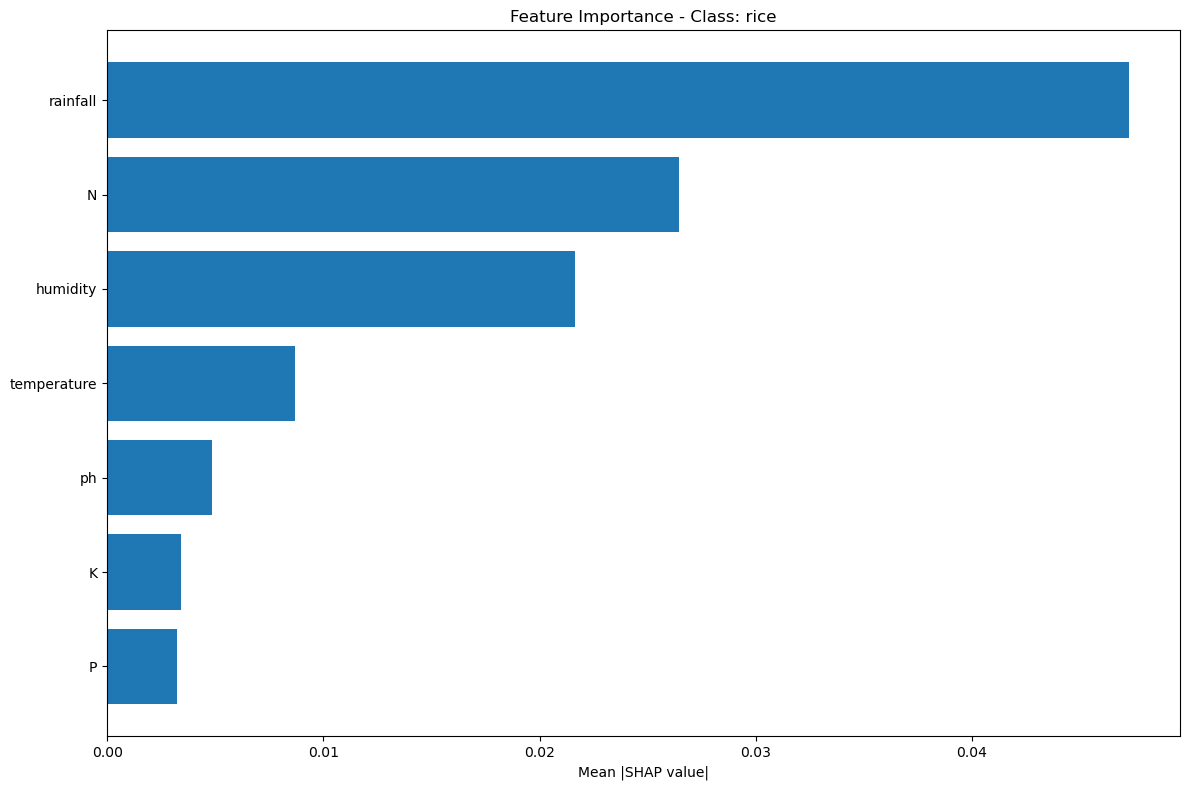


Top 10 important features for class 'rice':
  P: 0.003222
  K: 0.003406
  ph: 0.004857
  temperature: 0.008679
  humidity: 0.021625
  N: 0.026453
  rainfall: 0.047265


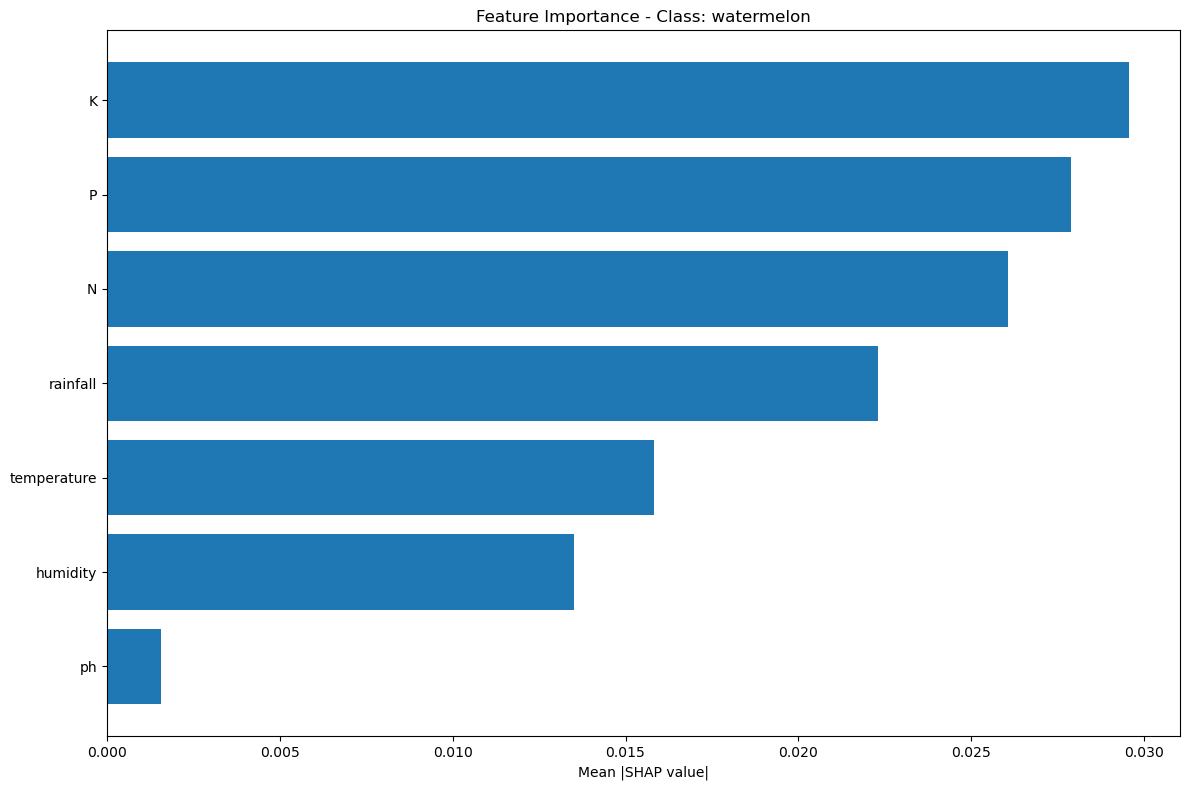


Top 10 important features for class 'watermelon':
  ph: 0.001568
  humidity: 0.013513
  temperature: 0.015816
  rainfall: 0.022296
  N: 0.026080
  P: 0.027901
  K: 0.029567


In [38]:
def plot_shap_importance():
    for idx, values in enumerate(class_shap):
        plt.figure(figsize = (12, 8))

        shap_importance = np.abs(values).mean(axis=0)
        sorted_idx = np.argsort(shap_importance)
        top = min(20, len(feature_names))

        f_sorted = [feature_names[i] for i in sorted_idx[-top:]]
        v_sorted = shap_importance[sorted_idx[-top:]]

        plt.barh(f_sorted, v_sorted)
        plt.xlabel("Mean |SHAP value|")
        plt.title(f"Feature Importance - Class: {label.classes_[idx]}")
        plt.tight_layout()
        plt.show()

        print(f"\nTop 10 important features for class '{label.classes_[idx]}':")
        for f, v in zip(f_sorted[-10:], v_sorted[-10:]):
            print(f"  {f}: {v:.6f}")

plot_shap_importance()


In [39]:
INSTANCE_IDX = 50
TOTAL_FEATURES = 7

print(f"\nAnalyzing instance #{INSTANCE_IDX}")

# Model prediction
x = X_test_scale[INSTANCE_IDX:INSTANCE_IDX+1].astype(np.float32)
with torch.no_grad():
    probs = F.softmax(model(torch.from_numpy(x)), dim=1).cpu().numpy()

pred_class = np.argmax(probs)
confidence = probs[0][pred_class]
pred_name = label.classes_[pred_class]

print(f"Predicted: {pred_name}")
print(f"Confidence: {confidence:.1%}\n")

# SHAP values and percentages
svals = class_shap[pred_class][INSTANCE_IDX][:TOTAL_FEATURES]
abs_vals = np.abs(svals)
percent = (abs_vals / abs_vals.sum()) * 100

sorted_idx = np.argsort(percent)[::-1]
features = [feature_names[i] for i in sorted_idx]
percent_sorted = percent[sorted_idx]
shap_sorted = svals[sorted_idx]



Analyzing instance #50
Predicted: papaya
Confidence: 99.5%



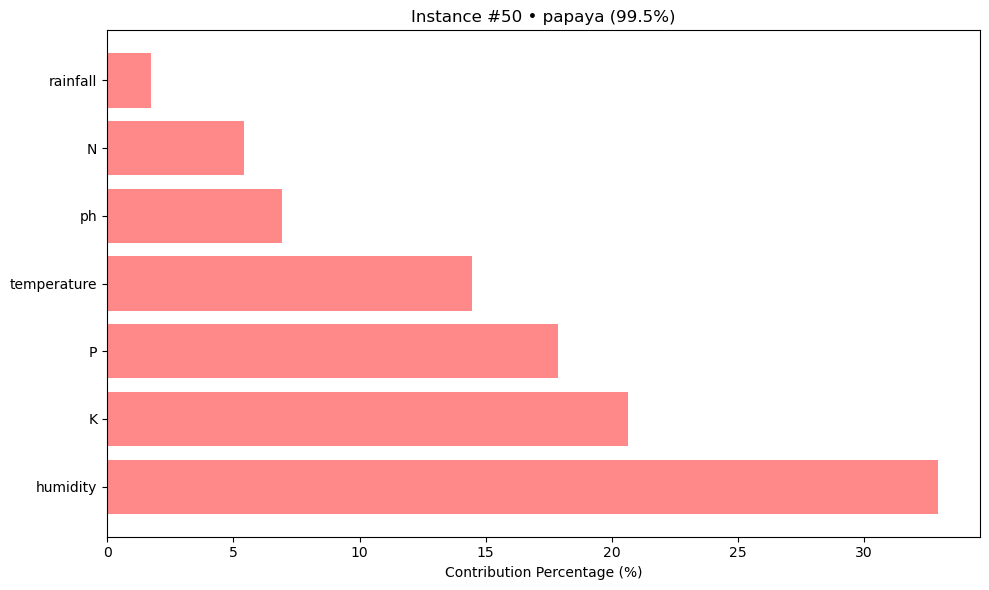

In [40]:
plt.figure(figsize = (10, 6))
colors = ['#FF6B6B' if v > 0 else '#4D96FF' for v in shap_sorted]
plt.barh(features, percent_sorted, color = colors, alpha = 0.8)
plt.xlabel("Contribution Percentage (%)")
plt.title(f"Instance #{INSTANCE_IDX} • {pred_name} ({confidence:.1%})")
plt.tight_layout()
plt.show()
 

In [41]:
print(f"\n{'Rank':<5}{'Feature':<15}{'Percent':<12}{'Direction':<10}{'SHAP Val':<10}")
print("-" * 55)

for i, idx in enumerate(sorted_idx):
    direction = "Positive" if shap_sorted[i] > 0 else "Negative"
    arrow = "↑" if shap_sorted[i] > 0 else "↓"
    print(f"{i+1:<5}{features[i]:<15}{percent_sorted[i]:>6.1f}%   "
          f"{arrow} {direction:<8}{shap_sorted[i]:>+8.4f}")



Rank Feature        Percent     Direction SHAP Val  
-------------------------------------------------------
1    humidity         32.9%   ↑ Positive +0.3210
2    K                20.7%   ↑ Positive +0.2013
3    P                17.9%   ↑ Positive +0.1740
4    temperature      14.5%   ↑ Positive +0.1409
5    ph                6.9%   ↑ Positive +0.0675
6    N                 5.4%   ↑ Positive +0.0527
7    rainfall          1.7%   ↑ Positive +0.0169


In [42]:
instance_values = X_test_scale[INSTANCE_IDX]
paragraph = []

for feature, p, sval, f_idx in zip(features, percent_sorted, shap_sorted, sorted_idx):
    val = instance_values[f_idx]
    dir_text = "positive influence" if sval > 0 else "negative influence"
    push = "pushing the model toward the prediction" if sval > 0 else "pulling it away"

    strength = (
        "strongly supported" if p >= 20 else
        "supported" if p >= 10 else
        "slightly influenced"
    )

    paragraph.append(
        f"{feature} ({val:.2f}) contributed {p:.1f}% with a {dir_text}, "
        f"{push}; this value {strength} the {pred_name} prediction."
    )

print("\nGenerated Explanation:\n")
print(" ".join(paragraph))



Generated Explanation:

humidity (0.96) contributed 32.9% with a positive influence, pushing the model toward the prediction; this value strongly supported the papaya prediction. K (0.20) contributed 20.7% with a positive influence, pushing the model toward the prediction; this value strongly supported the papaya prediction. P (0.45) contributed 17.9% with a positive influence, pushing the model toward the prediction; this value supported the papaya prediction. temperature (0.93) contributed 14.5% with a positive influence, pushing the model toward the prediction; this value supported the papaya prediction. ph (0.48) contributed 6.9% with a positive influence, pushing the model toward the prediction; this value slightly influenced the papaya prediction. N (0.56) contributed 5.4% with a positive influence, pushing the model toward the prediction; this value slightly influenced the papaya prediction. rainfall (1.00) contributed 1.7% with a positive influence, pushing the model toward th

In [43]:
background_df = pd.DataFrame(background, columns=feature_names)
background_df.to_csv("bg.csv", index=False)
